# Boxplot of MZmine 3, PeakDetective, PeakFormer

## MZmine 3 boxplot

In [61]:
import warnings
import pandas as pd
import os
import re
warnings.filterwarnings("ignore")

In [62]:
def filter_data(mzmine_path, benchmark_path, type):
    if type == 'TOF' or type == 'TOFShift':
        keys = ['rt', 'mz', 'rt_range:min', 'rt_range:max',
                'datafile:20170326-960MIX_SampleA_1.mzML:area', 'datafile:20170326-960MIX_SampleA_2.mzML:area',
                'datafile:SampleA_4-20170326-960MIX_SampleA_5.mzML:area',
                'datafile:SampleA_3-20170326-960MIX_SampleA_4.mzML:area',
                'datafile:20170326-960MIX_SampleB_1.mzML:area', 'datafile:20170326-960MIX_SampleB_2.mzML:area',
                'datafile:20170326-960MIX_SampleB_3.mzML:area', 'datafile:20170326-960MIX_SampleB_4.mzML:area'
                ]

    elif type == 'QE' or type == 'QEShift':
        keys = ['rt', 'mz', 'rt_range:min', 'rt_range:max',
                'datafile:SA1.mzML:area', 'datafile:SA2.mzML:area','datafile:SA3.mzML:area', 'datafile:SA4.mzML:area',
                'datafile:SA5.mzML:area','datafile:SB1.mzML:area', 'datafile:SB2.mzML:area','datafile:SB3.mzML:area',
                'datafile:SB4.mzML:area','datafile:SB5.mzML:area'
                ]
    df_mzmine = pd.read_csv(mzmine_path, usecols=keys)
    df_benchmark = pd.read_csv(benchmark_path)
    df_clean = df_mzmine[(df_mzmine != 0).all(axis=1)]  
    df_cleaned = df_clean[df_clean.notnull().all(axis=1)]  
    return df_cleaned, df_benchmark

def find_couple(df_cleaned, df_benchmark, ppm, rtTol=0.5):

    for index, row in df_benchmark.iterrows():

        mz_tolerance = ppm * row["mz"] / 1e6
        mz_bounds = [row["mz"] - mz_tolerance, row["mz"] + mz_tolerance]

        matching_rows \
            = df_cleaned[(df_cleaned["mz"] > mz_bounds[0]) & (df_cleaned["mz"] < mz_bounds[1])]

        matching_match = matching_rows.loc[matching_rows['rt'].between(row['RT'] - rtTol, row['RT'] + rtTol)]

        if matching_rows.empty or matching_match.empty:
            df_benchmark.at[index, 'tag'] = 0
        else:
            for i, row1 in matching_match.iterrows():
                df_cleaned.at[i, 'True RT'] = row['RT']
                df_cleaned.at[i, 'Compound Name'] = int(row['Compound Name'])
                df_cleaned.at[i, 'Fold change'] = row['Fold change']
                df_cleaned.at[i, 'Compound concentration ratio'] = row['Compound concentration ratio']
                df_cleaned.at[i,'p-value'] = row['p-value']

    return df_cleaned, df_benchmark

def plot_venn(df1, df2, type, name):
    set1 = set(df1['Compound Name'])
    set2 = set(df2['Compound Name'])
    venn2([set1, set2],
          set_labels=["mzmine", "benchmark"], set_colors=["green", "grey"])
    plt.tight_layout()
    # plt.savefig(f"{type}+{name}.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()


def plot_boxplot(df, name, type, precision, lim, n='fc'):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    graph = ax.boxplot(
        [
            df[df["Compound concentration ratio"] == "1/16"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/4"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/2"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "2/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "4/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "16/1"].loc[:, n],
        ],
        vert=True,
        patch_artist=True,
        labels=["Gd1", "Gd2", "Gd3", "Gdm", "Gd4", "Gd5", "Gd6"],
        sym='*'
    )

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(graph['boxes'], colors):
        patch.set_facecolor(color)
    plt.tight_layout()

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    plt.yscale('log', base=2)
    import numpy as np
    if lim!=0:
        plt.ylim(1 / 2 ** lim,  2 ** lim)
    ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    # plt.savefig(f"{type}+{name}+{precision}.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()


def compute_average_and_cv(group_name, column_names, df):
    try:
        group_columns = [f'{column_name}' for column_name in column_names]

        relevant_data = df.select_dtypes(include='number')[group_columns]

        avg = relevant_data.mean(axis=1)
        std = relevant_data.std(axis=1)


        cv = std.where(std != 0, 0) / avg * 100

        return {'AVG': avg, 'CV': cv}
    except Exception as e:
        print(f"Error processing group {group_name}: {e}")
        return {}


def plot_log(df1, type, name, save=False, lim=0):
    df1 = df1[df1.notnull().all(axis=1)] 
    if type == 'TOF' or type == 'TOFShift':
        import pandas as pd

        sample_a_columns = ['datafile:20170326-960MIX_SampleA_1.mzML:area',
                            'datafile:20170326-960MIX_SampleA_2.mzML:area',
                            'datafile:SampleA_4-20170326-960MIX_SampleA_5.mzML:area',
                            'datafile:SampleA_3-20170326-960MIX_SampleA_4.mzML:area']

        sample_b_columns = ['datafile:20170326-960MIX_SampleB_1.mzML:area',
                            'datafile:20170326-960MIX_SampleB_2.mzML:area',
                            'datafile:20170326-960MIX_SampleB_3.mzML:area',
                            'datafile:20170326-960MIX_SampleB_4.mzML:area']
    elif type == 'QE' or type == 'QEShift':
        sample_a_columns = ['datafile:SA1.mzML:area', 'datafile:SA2.mzML:area',
                            'datafile:SA3.mzML:area', 'datafile:SA4.mzML:area',
                            'datafile:SA5.mzML:area']
        sample_b_columns = ['datafile:SB1.mzML:area', 'datafile:SB2.mzML:area',
                            'datafile:SB3.mzML:area', 'datafile:SB4.mzML:area',
                            'datafile:SB5.mzML:area']

    sample_a_results = compute_average_and_cv('SampleA', sample_a_columns, df1)
    sample_b_results = compute_average_and_cv('SampleB', sample_b_columns, df1)

    df1.loc[:, 'AVG-A'] = sample_a_results['AVG']
    df1.loc[:, 'CV-A'] = sample_a_results['CV']
    df1.loc[:, 'AVG-B'] = sample_b_results['AVG']
    df1.loc[:, 'CV-B'] = sample_b_results['CV']

    df1.loc[:, 'fc'] = df1.loc[:, 'AVG-B'] / df1.loc[:, 'AVG-A']
    df1.loc[:, 'ratio'] = df1.loc[:, 'fc'] / df1.loc[:, 'Fold change']

    df1 = df1.sort_values(by='Compound Name')
    duplicate_rows = df1[df1.duplicated(subset=['Compound Name'], keep=False)]
    from itertools import groupby
    grouped = [(key, list(group)) for key, group in
                groupby(duplicate_rows.index, key=lambda x: duplicate_rows.loc[x, duplicate_rows.columns[-10]])]

    other_numbers_in_group = []
    for key, group in grouped:
        min_id = min(group, key=lambda x: (abs(duplicate_rows.loc[x, 'rt'] - duplicate_rows.loc[x, 'True RT'])))


        for id in group:
            if id != min_id:
                other_numbers_in_group.append(id)

    df1.drop(other_numbers_in_group, inplace=True)

    score = calculate_precision(df1, name, type)
    print(score)
    plot_boxplot(df1, name, type, score,lim)
    if save:
        df1.to_csv(f'{type}.csv', index=False)


def calculate_precision(df, name, type):
    print(f'{type}+{name}')
    df_filtered = df[(df['ratio'] > 0.8) & (df['ratio'] < 1.2)]
    count = df_filtered.shape[0]
    print(f"precise quantify:{count}")
    print(f"count:{df.shape[0]}",)
    if type == 'TOF' or type == 'TOFShift':
        return round((count/df.shape[0] + df.shape[0] / 970)/2, 3)
    elif type == 'QE' or type == 'QEShift':
        return round((count/df.shape[0] + df.shape[0] / 836)/2, 3)

In [63]:
def boxplot(mzmine_dir, benchmark_path, type):
    for mzmine_path in os.listdir(mzmine_dir):
        mzmine_path = os.path.join(mzmine_dir, mzmine_path)

        df1, df2 = filter_data(mzmine_path, benchmark_path, type)
        match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
        if match:
            number1 = int(match.group(1))
            number2 = float(match.group(2))
            df1, df2 = find_couple(df1, df2, number1, number2)
            plot_log(df1, type, name=number1 + number2)

### Ground Truth

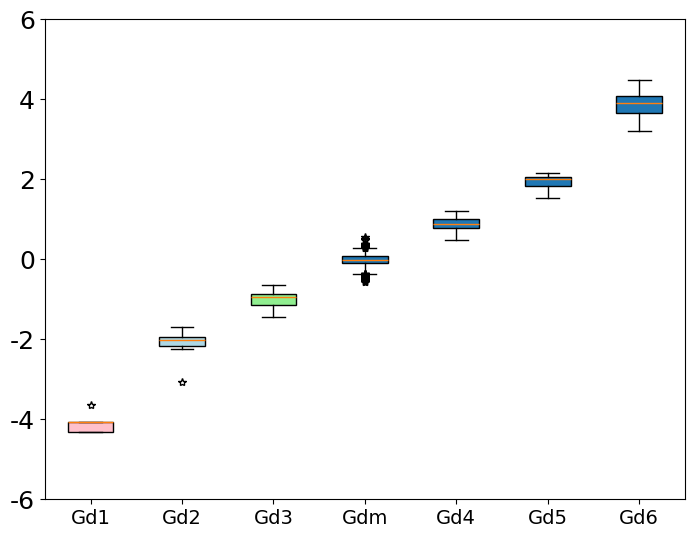

In [64]:
benchmark_path = 'data/FeatureQE.csv'
type = 'QE'
df1 = pd.read_csv(benchmark_path)
plot_boxplot(df1, name='QE', type='QE', precision=0, lim=6,n='Fold change')

### QE-benchmark feature table

QE+10.1
precise quantify:609
count:797
0.859


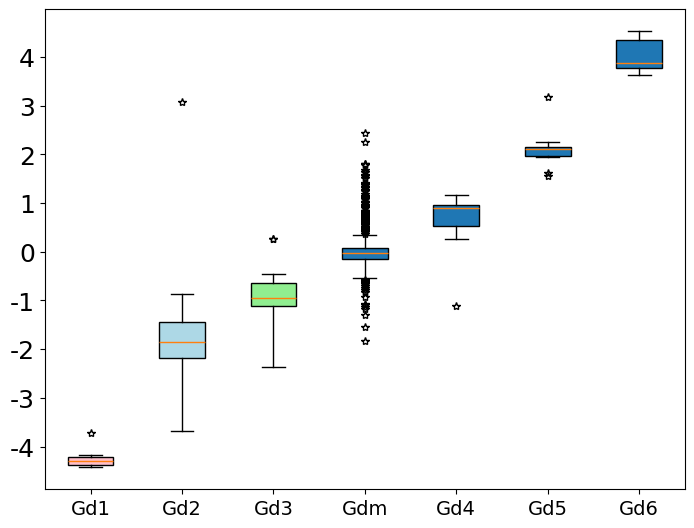

QE+10.3
precise quantify:784
count:823
0.969


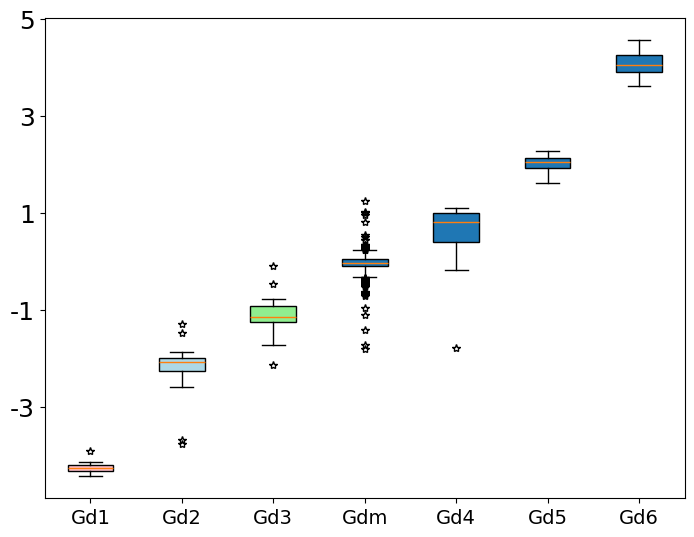

QE+10.2
precise quantify:748
count:826
0.947


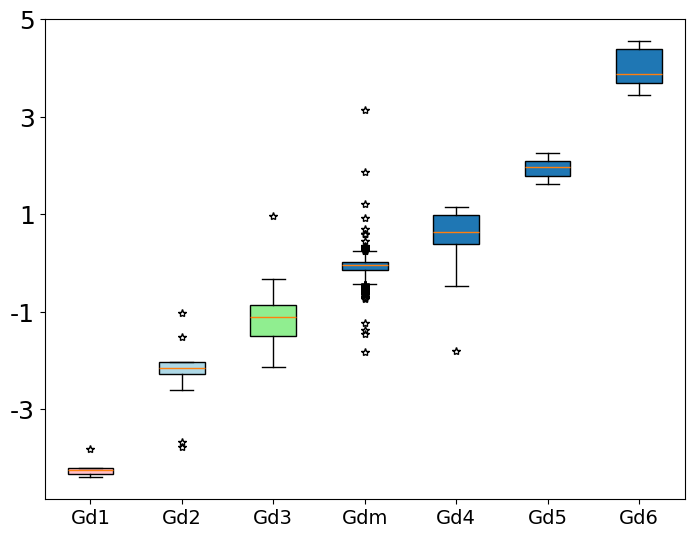

QE+10.5
precise quantify:766
count:821
0.958


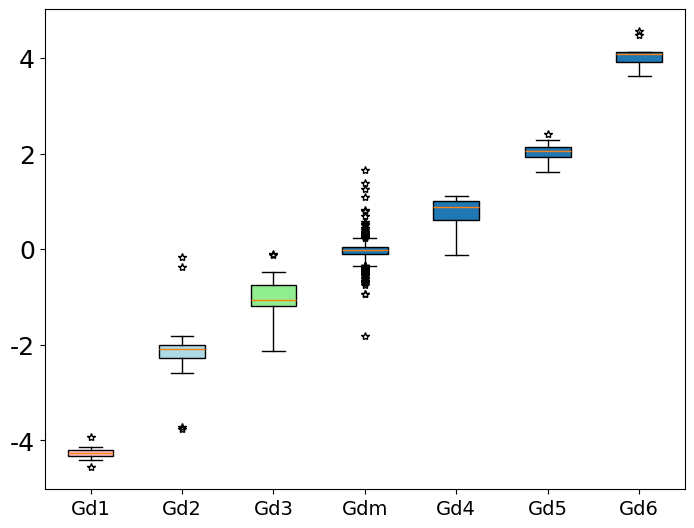

QE+10.4
precise quantify:780
count:822
0.966


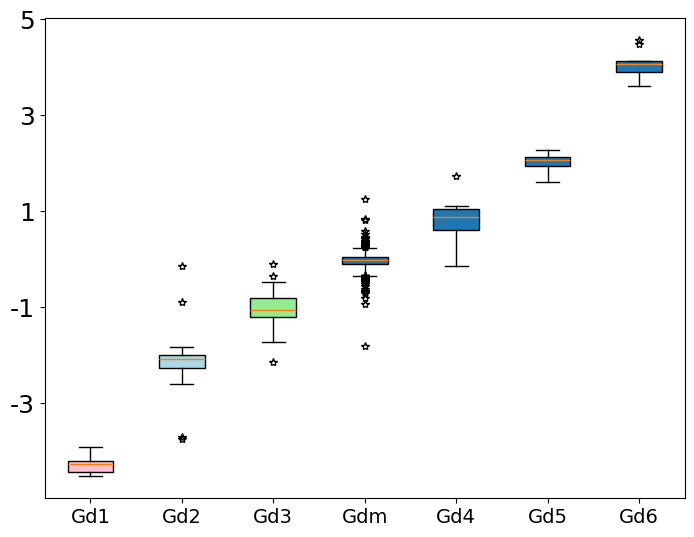

QE+15.4
precise quantify:784
count:824
0.969


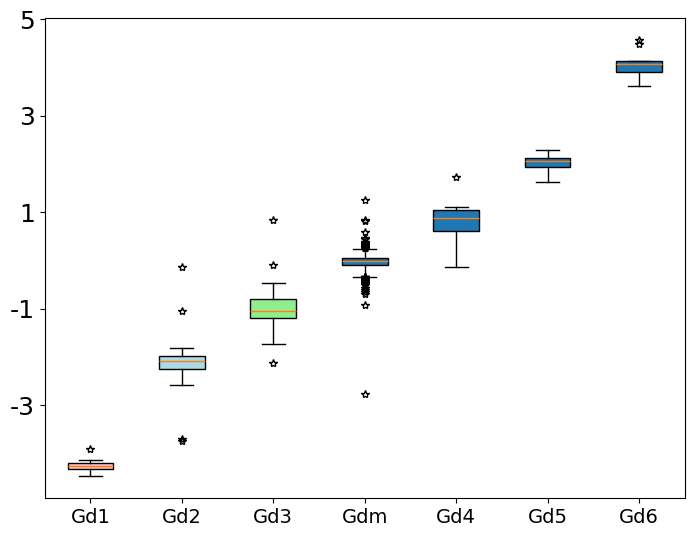

QE+5.4
precise quantify:765
count:823
0.957


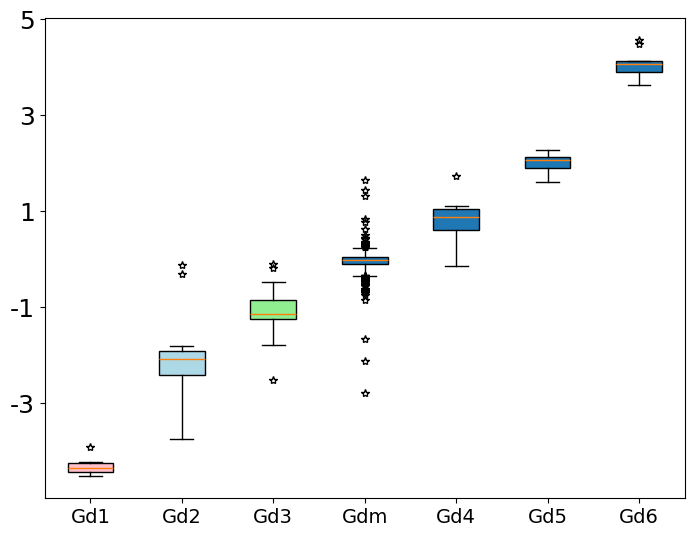

QE+5.5
precise quantify:747
count:823
0.946


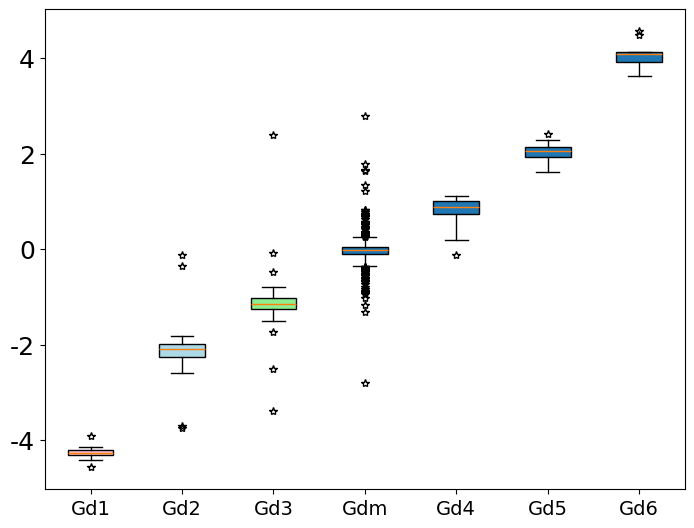

QE+15.5
precise quantify:777
count:823
0.964


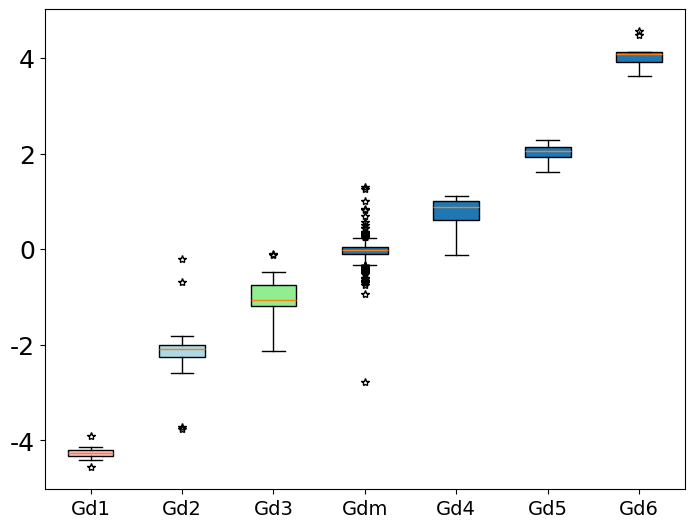

QE+15.2
precise quantify:749
count:827
0.947


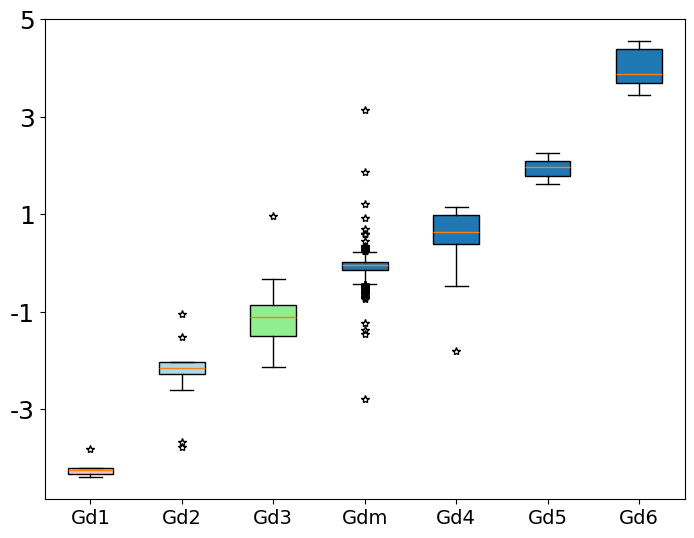

QE+5.2
precise quantify:748
count:825
0.947


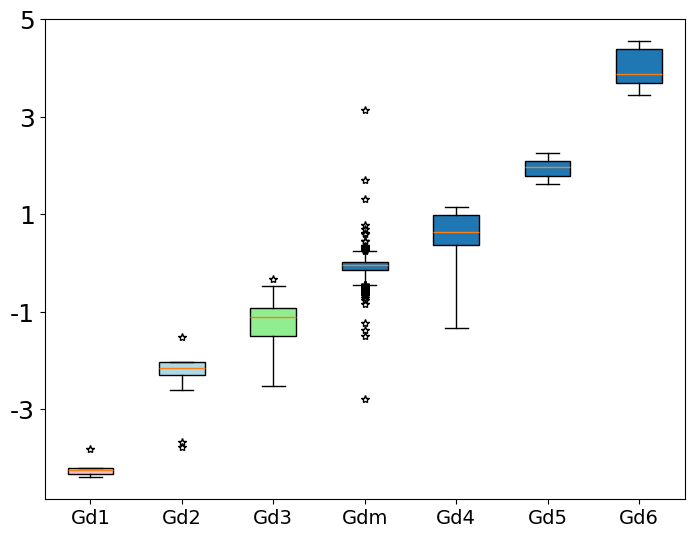

QE+5.3
precise quantify:783
count:823
0.968


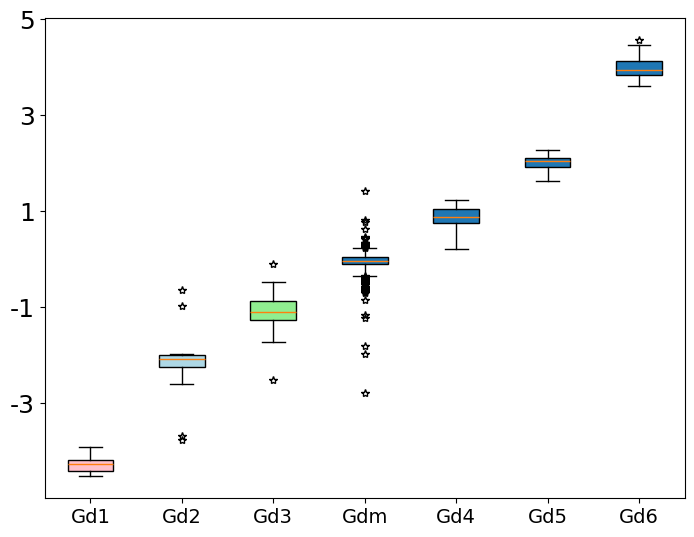

QE+15.3
precise quantify:789
count:825
0.972


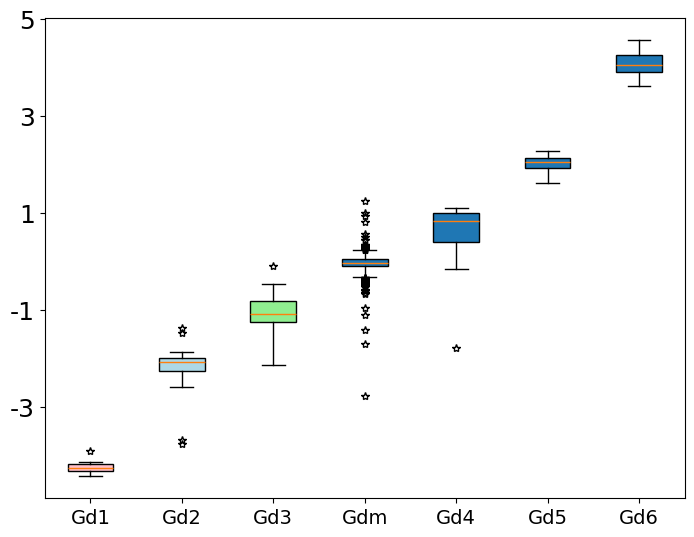

QE+15.1
precise quantify:610
count:797
0.859


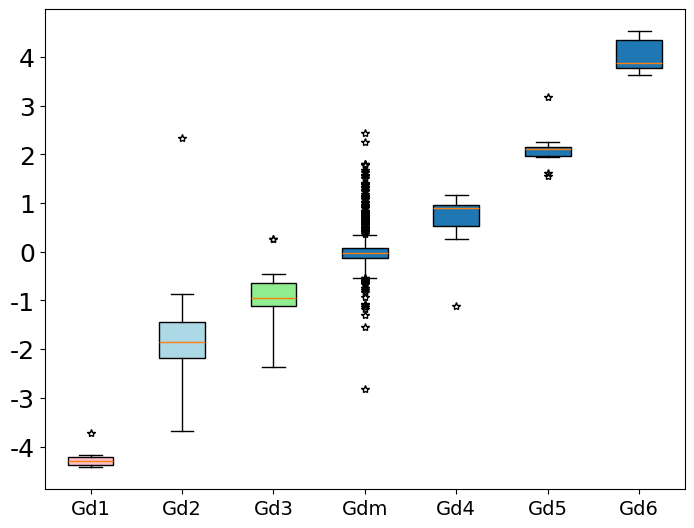

QE+5.1
precise quantify:614
count:795
0.862


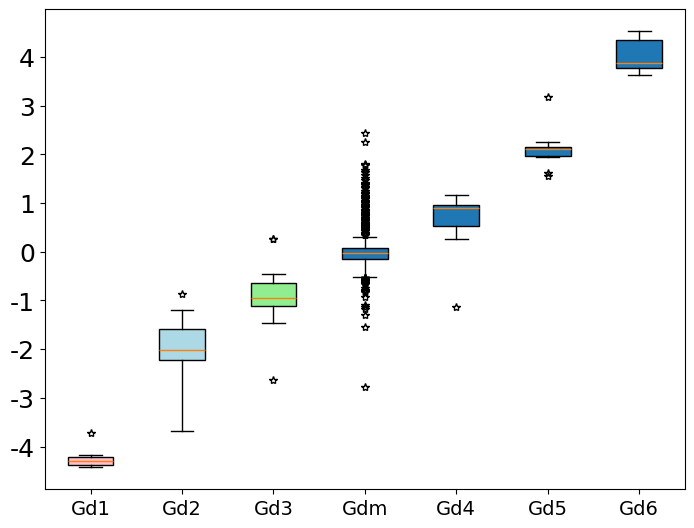

In [65]:
mzmine_dir = 'data/MZMINE3/QE-raw'
benchmark_path = 'data/FeatureQE.csv'
type = 'QE'
boxplot(mzmine_dir, benchmark_path, type)

#### The best is 15.3, which means ppm=15, rt_tolerance = 0.3

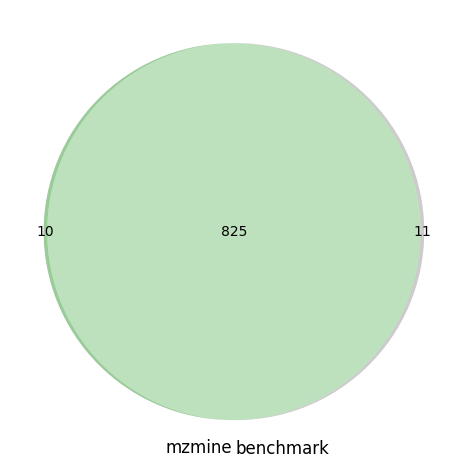

QE+15.3
precise quantify:789
count:825
0.972


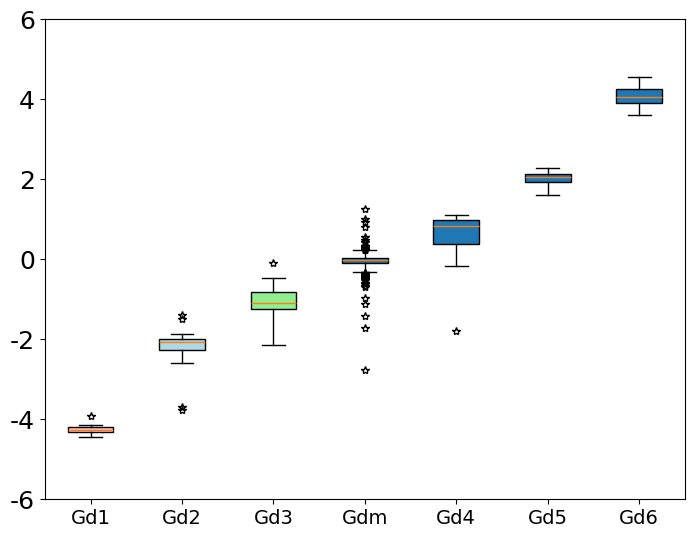

In [66]:
mzmine_path = 'data/MZMINE3/QE-raw/Aligned_feature_list_gap-filled-15-0.3.csv'
def plot_best(mzmine_path, benchmark_path, type):
    df1, df2 = filter_data(mzmine_path, benchmark_path, type)
    match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
    if match:
        number1 = int(match.group(1)) 
        number2 = float(match.group(2)) 
        df1, df2 = find_couple(df1, df2, number1, number2)
        plot_venn(df1, df2, type, name=number1 + number2)
        plot_log(df1, type, name=number1 + number2, lim=6, save=True)
plot_best(mzmine_path, benchmark_path, type)

### QE- feature table with RT drift

QEShift+10.1
precise quantify:225
count:414
0.519


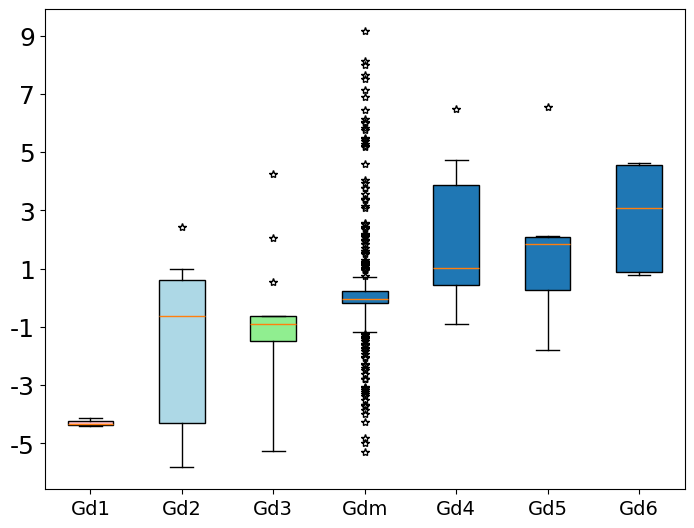

QEShift+10.3
precise quantify:686
count:823
0.909


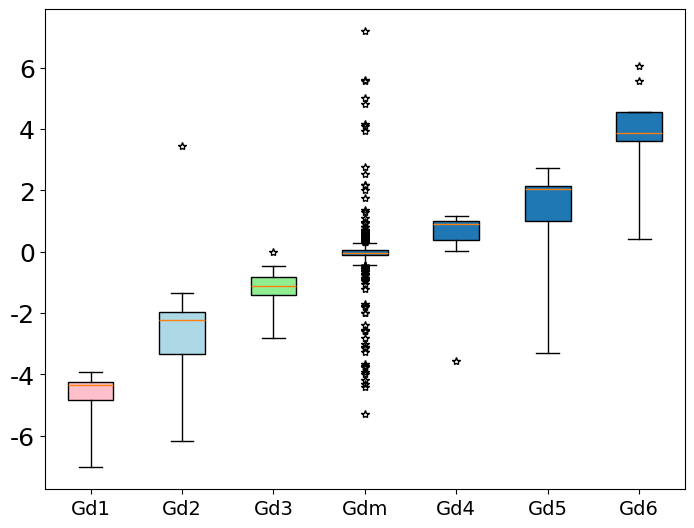

QEShift+10.2
precise quantify:572
count:768
0.832


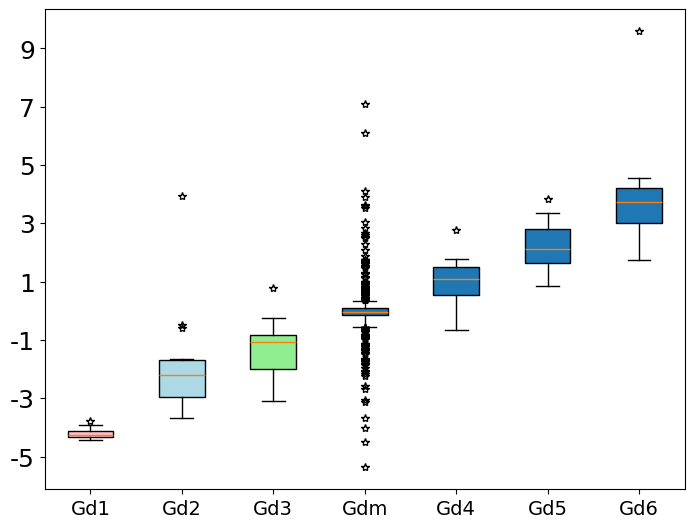

QEShift+10.5
precise quantify:664
count:821
0.895


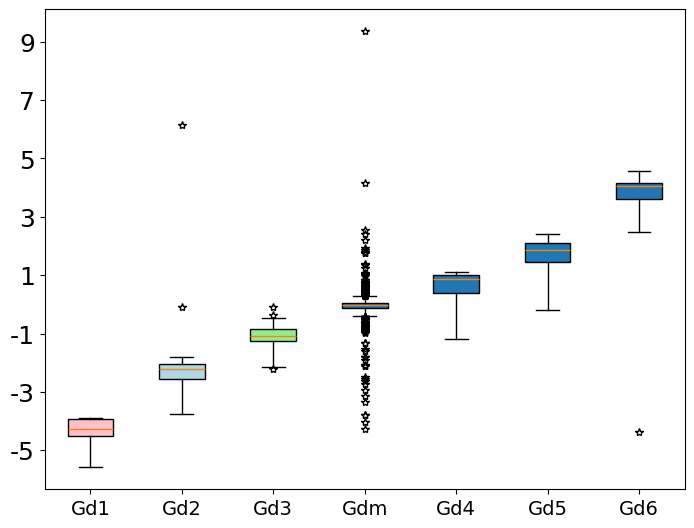

QEShift+10.4
precise quantify:680
count:822
0.905


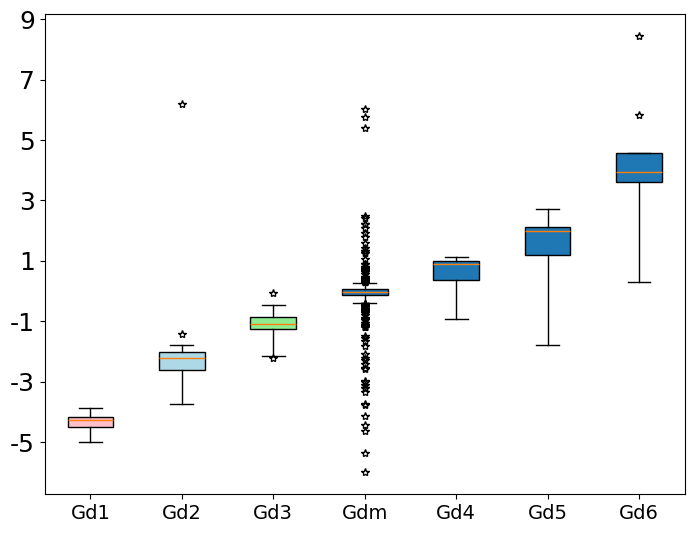

QEShift+15.4
precise quantify:687
count:823
0.91


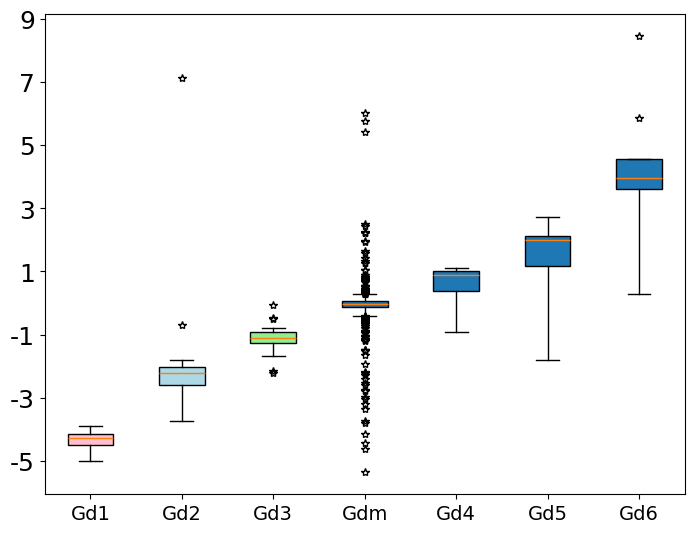

QEShift+5.4
precise quantify:667
count:823
0.897


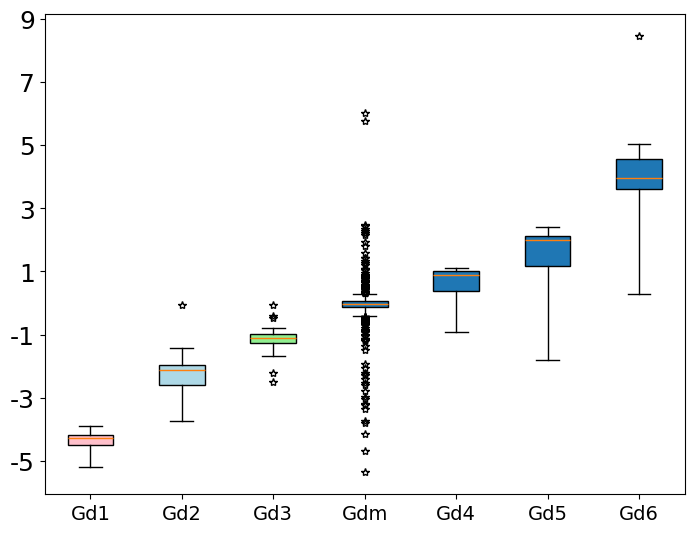

QEShift+5.5
precise quantify:651
count:823
0.888


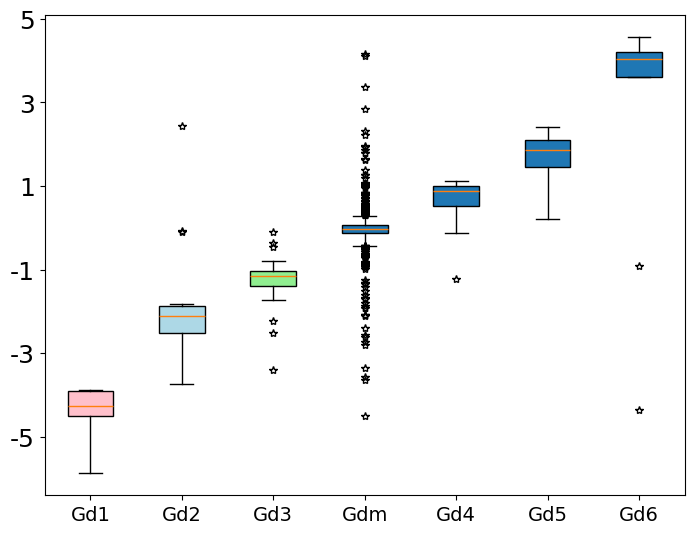

QEShift+15.5
precise quantify:673
count:823
0.901


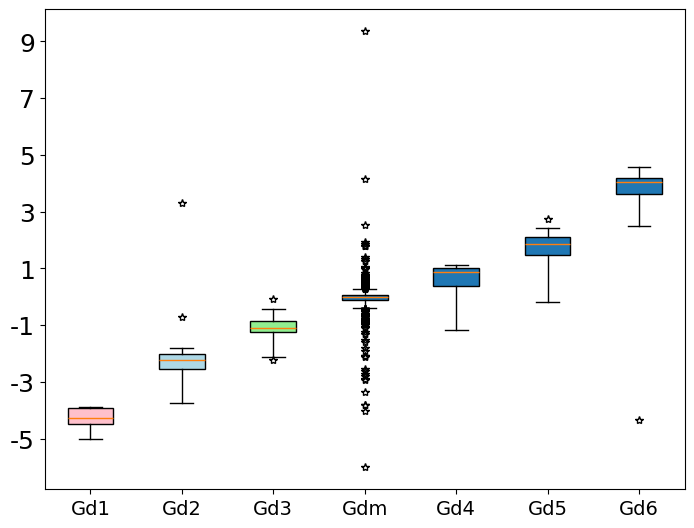

QEShift+15.2
precise quantify:570
count:768
0.83


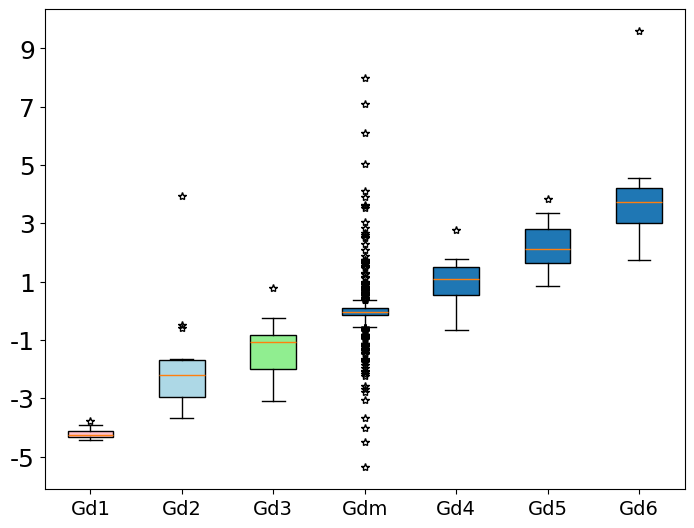

QEShift+5.2
precise quantify:565
count:767
0.827


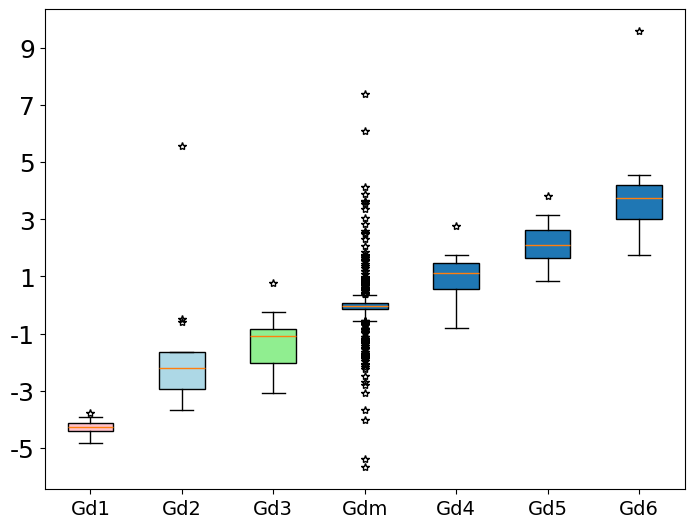

QEShift+5.3
precise quantify:673
count:823
0.901


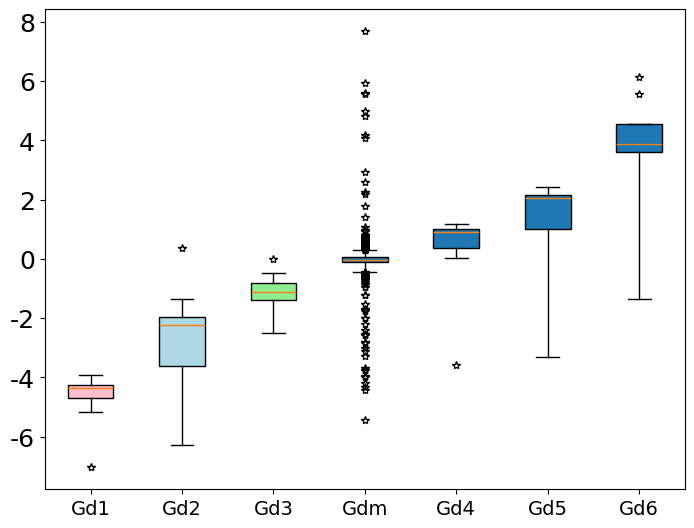

QEShift+15.3
precise quantify:690
count:824
0.912


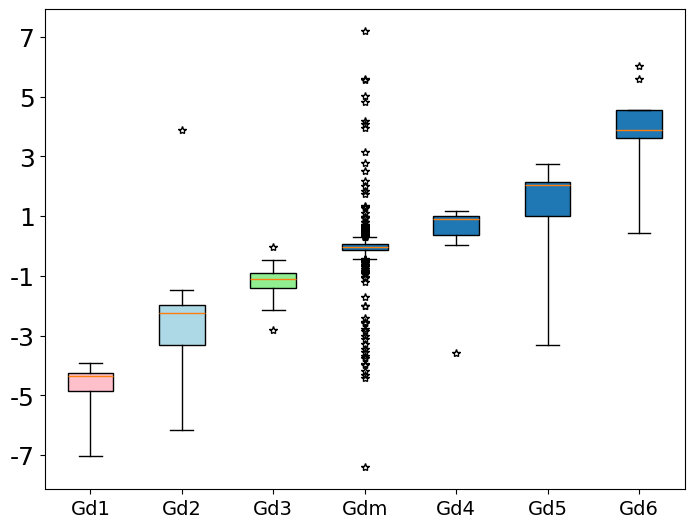

QEShift+15.1
precise quantify:226
count:414
0.521


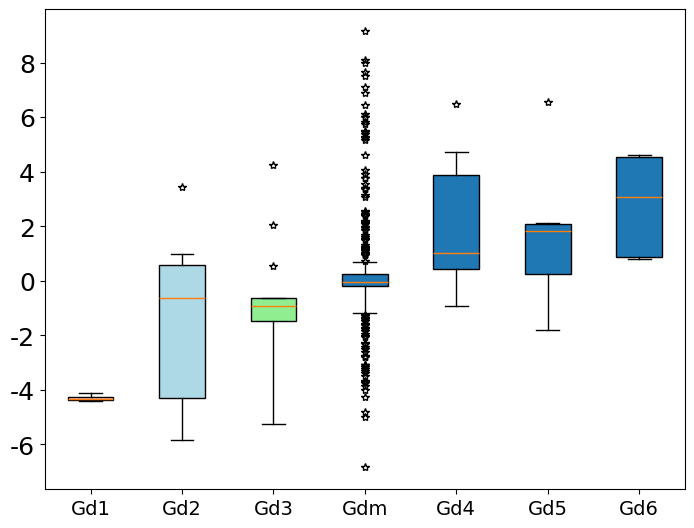

QEShift+5.1
precise quantify:219
count:414
0.512


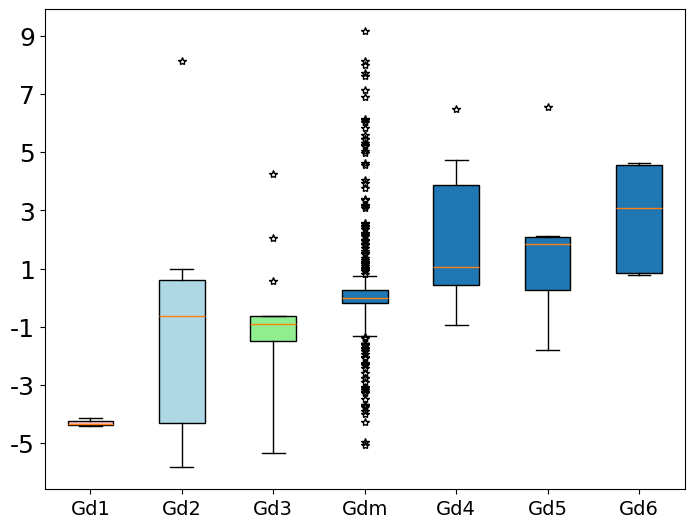

In [67]:
mzmine_dir = 'data/MZMINE3/QEShift-raw'
benchmark_path = 'data/FeatureQEShift.csv'
type = 'QEShift'
boxplot(mzmine_dir, benchmark_path, type)

### The best is 15.3, which means ppm=15, rt_tolerance = 0.3

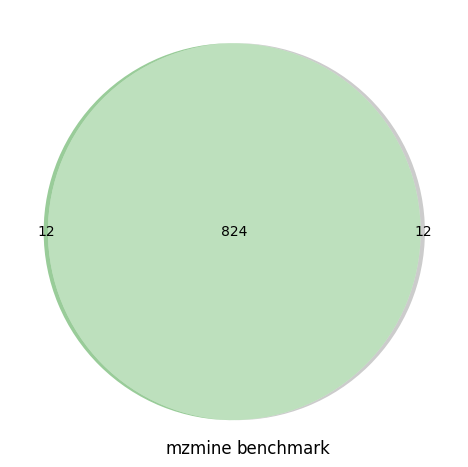

QEShift+15.3
precise quantify:690
count:824
0.912


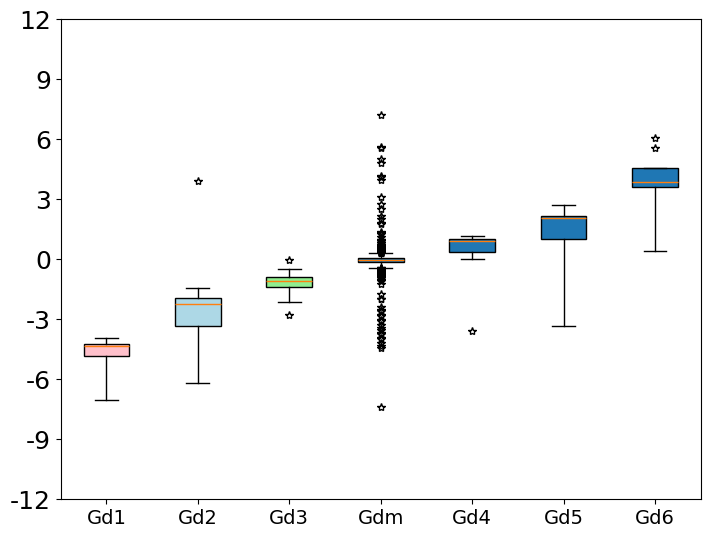

In [68]:
mzmine_path = 'data/MZMINE3/QEShift-raw/Aligned_feature_list_gap-filled-15-0.3.csv'
def plot_best(mzmine_path, benchmark_path, type):
    df1, df2 = filter_data(mzmine_path, benchmark_path, type)
    match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
    if match:
        number1 = int(match.group(1)) 
        number2 = float(match.group(2)) 
        df1, df2 = find_couple(df1, df2, number1, number2)
        plot_venn(df1, df2, type, name=number1 + number2)
        plot_log(df1, type, name=number1 + number2, lim=12, save=True)
plot_best(mzmine_path, benchmark_path, type)

## Ground Truth

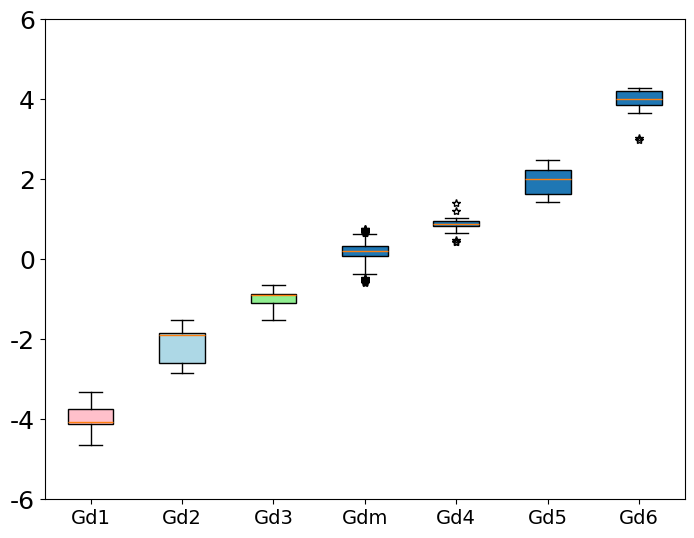

In [69]:
benchmark_path = 'data/FeatureTOF.csv'
type = 'TOF'
df1 = pd.read_csv(benchmark_path)
plot_boxplot(df1, name='TOF', type='TOF', precision=0, lim=6,n='Fold change')

### TOF-benchmark feature table

TOF+10.1
precise quantify:495
count:579
0.726


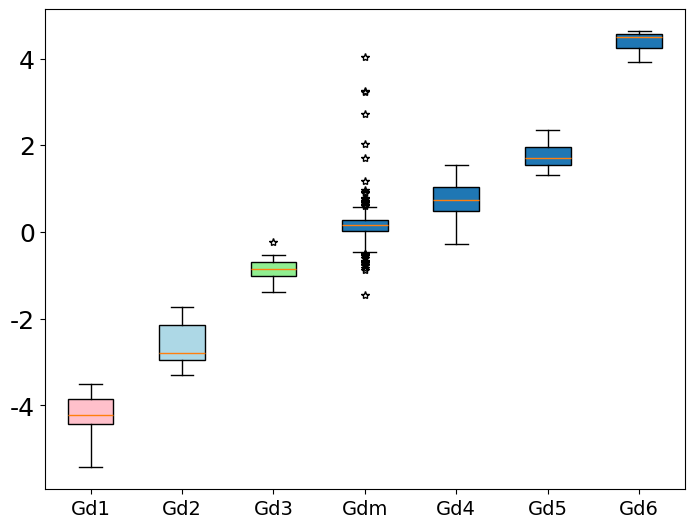

TOF+10.3
precise quantify:745
count:905
0.878


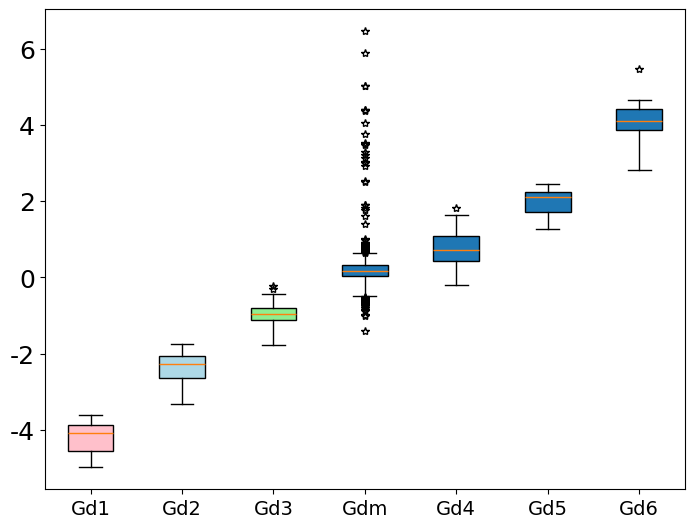

TOF+10.2
precise quantify:639
count:755
0.812


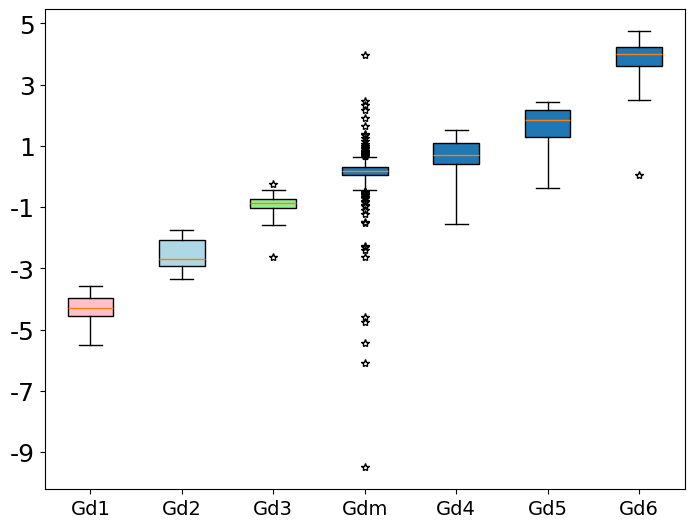

TOF+10.5
precise quantify:796
count:914
0.907


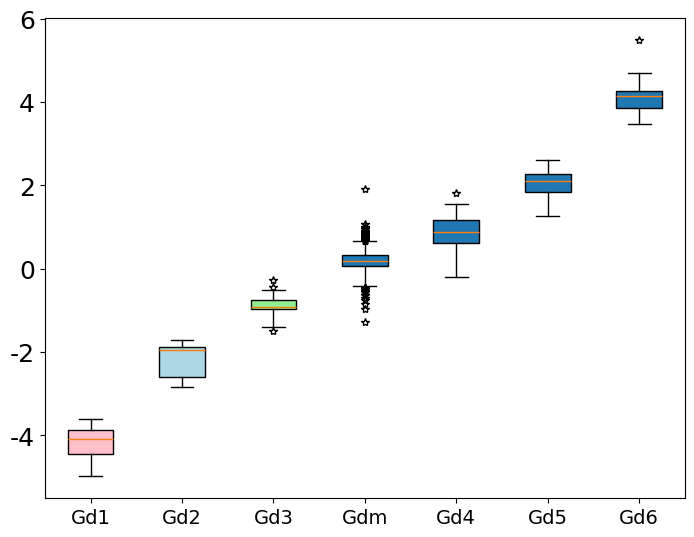

TOF+10.4
precise quantify:787
count:914
0.902


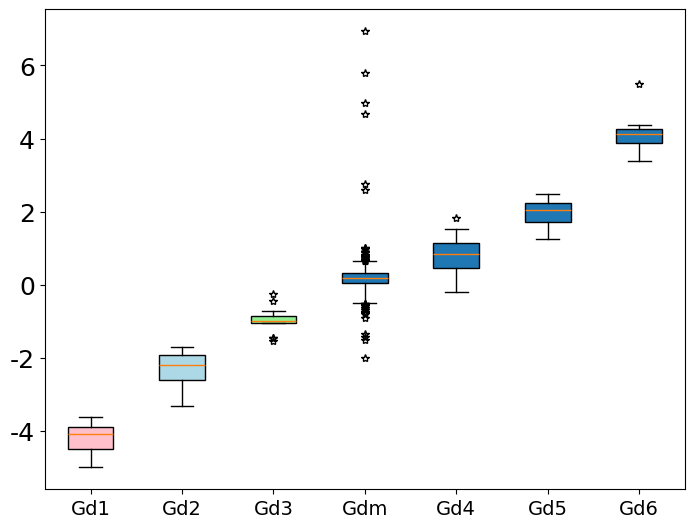

TOF+15.4
precise quantify:797
count:916
0.907


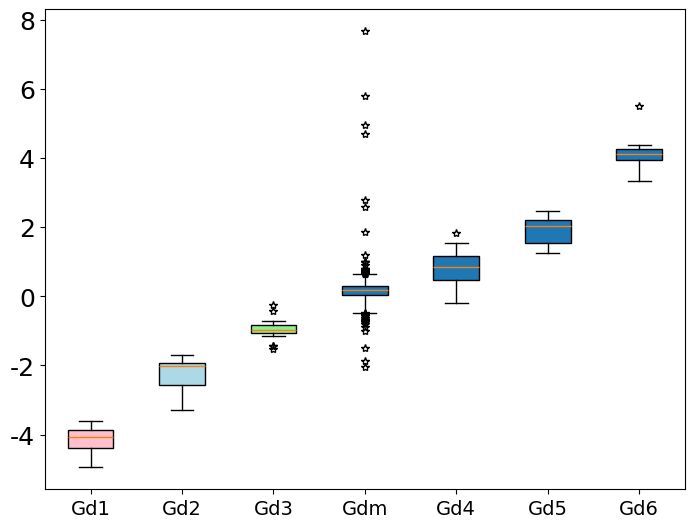

TOF+5.4
precise quantify:703
count:902
0.855


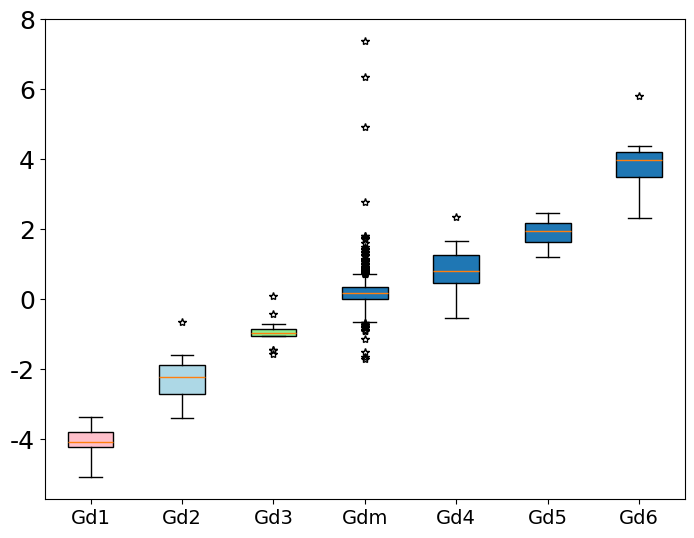

TOF+5.5
precise quantify:699
count:906
0.853


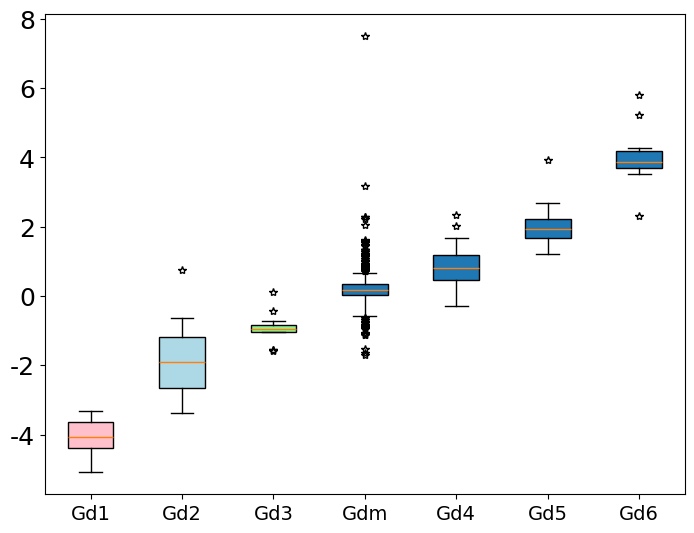

TOF+15.5
precise quantify:799
count:915
0.908


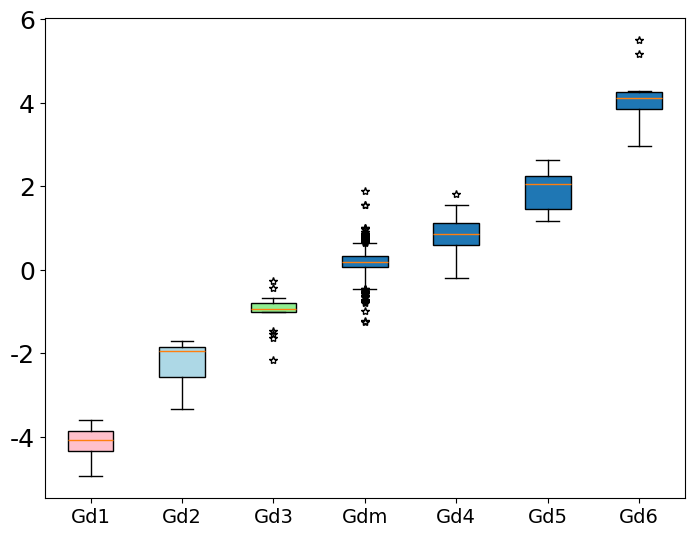

TOF+15.2
precise quantify:645
count:754
0.816


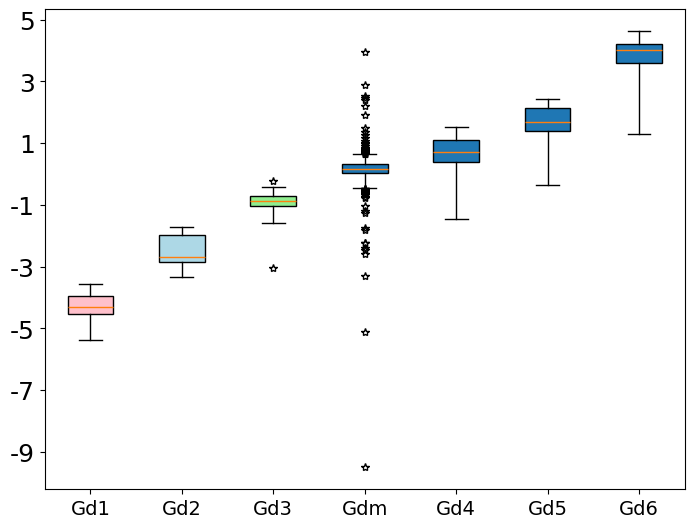

TOF+5.2
precise quantify:563
count:770
0.762


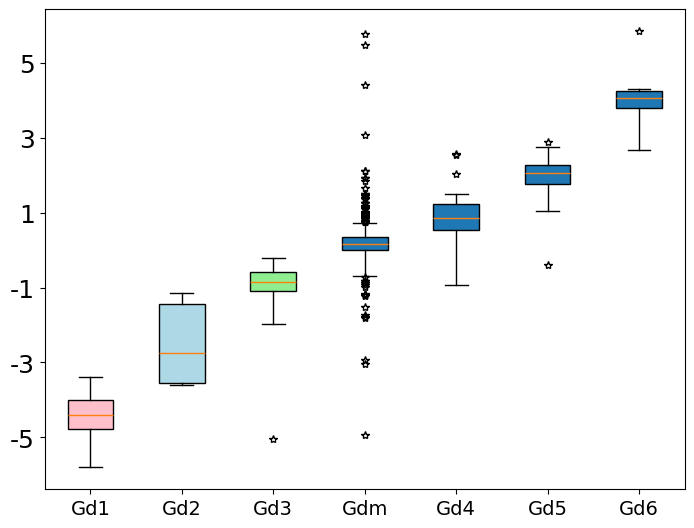

TOF+5.3
precise quantify:660
count:896
0.83


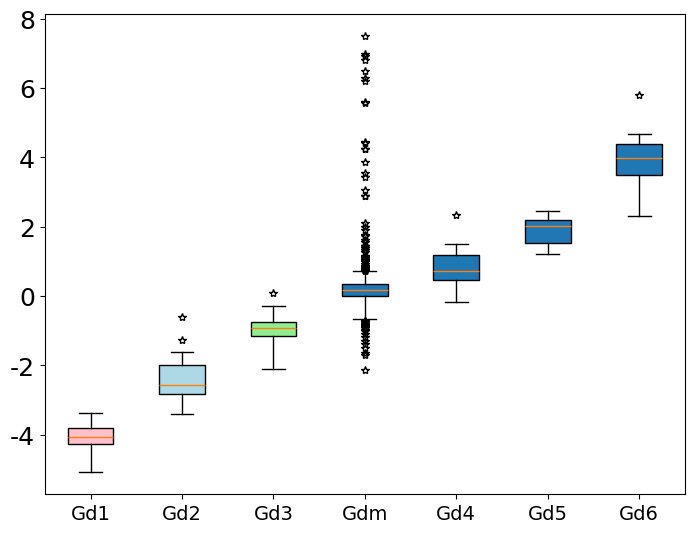

TOF+15.3
precise quantify:742
count:907
0.877


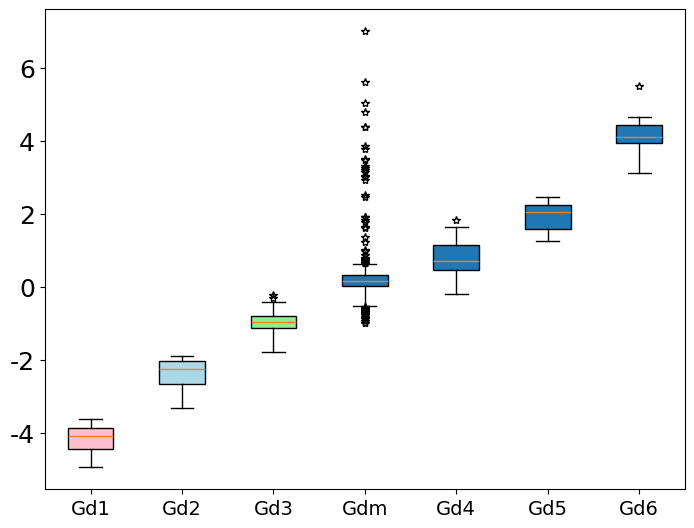

TOF+15.1
precise quantify:500
count:576
0.731


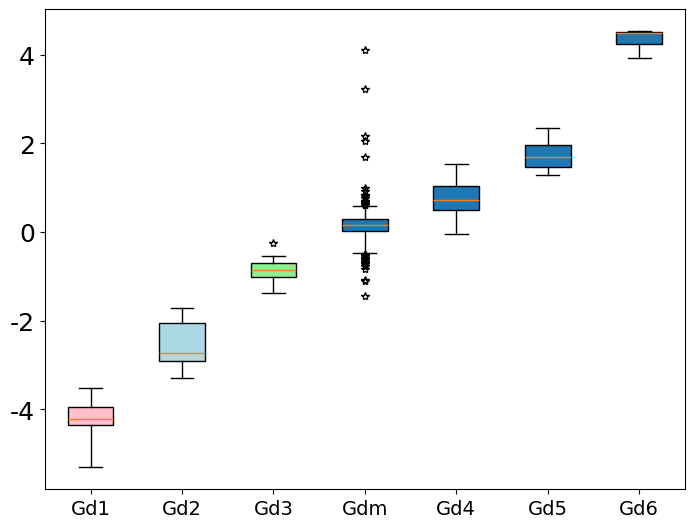

TOF+5.1
precise quantify:153
count:263
0.426


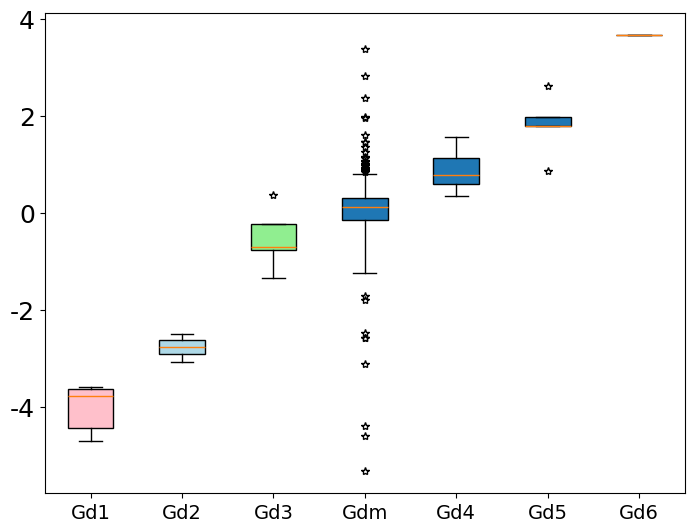

In [70]:
mzmine_dir = 'data/MZMINE3/TOF-raw'
benchmark_path = 'data/FeatureTOF.csv'
type = 'TOF'
boxplot(mzmine_dir, benchmark_path, type)

### The best is 15.5, which means ppm=15, rt_tolerance = 0.5

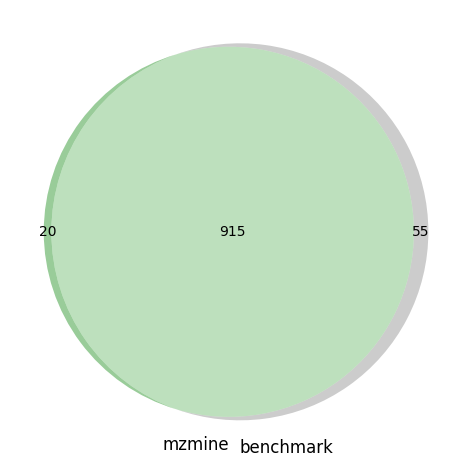

TOF+15.5
precise quantify:799
count:915
0.908


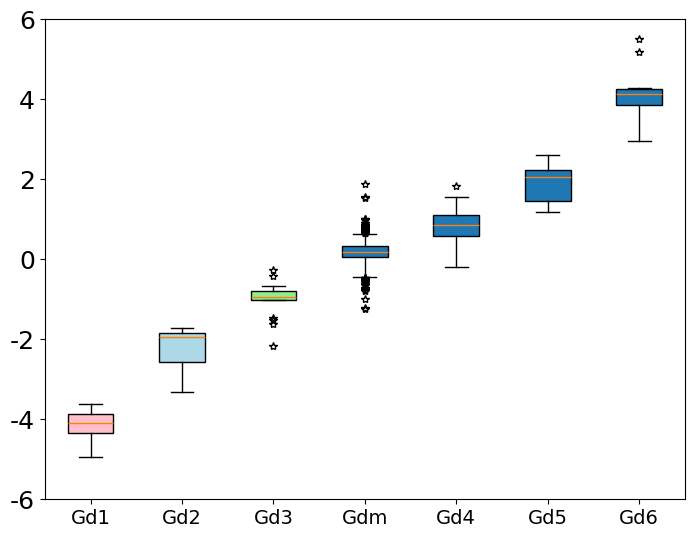

In [71]:
mzmine_path = 'data/MZMINE3/TOF-raw/Aligned_feature_list_gap-filled-15-0.5.csv'
def plot_best(mzmine_path, benchmark_path, type):
    df1, df2 = filter_data(mzmine_path, benchmark_path, type)
    match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
    if match:
        number1 = int(match.group(1)) 
        number2 = float(match.group(2)) 
        df1, df2 = find_couple(df1, df2, number1, number2)
        plot_venn(df1, df2, type, name=number1 + number2)
        plot_log(df1, type, name=number1 + number2, lim=6, save=True)
plot_best(mzmine_path, benchmark_path, type)

### TOF- feature table with RT drift

TOFShift+10.1
precise quantify:166
count:259
0.454


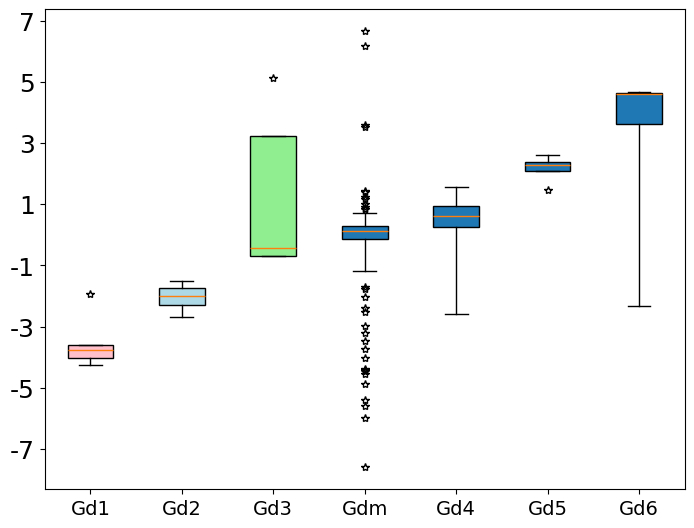

TOFShift+10.3
precise quantify:612
count:880
0.801


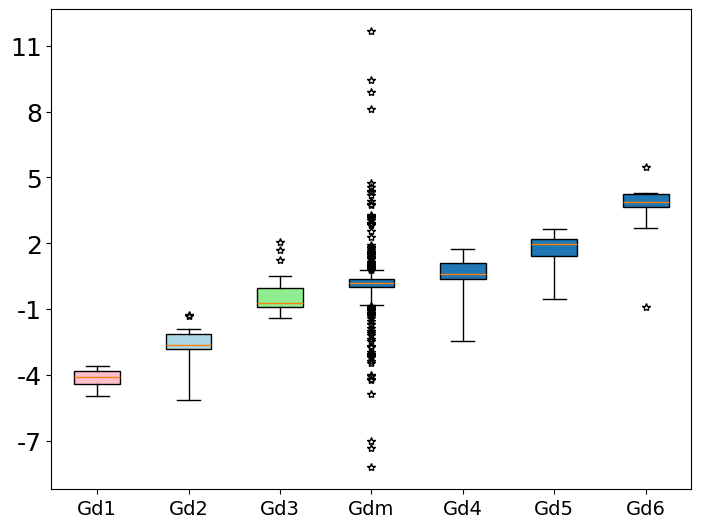

TOFShift+10.2
precise quantify:484
count:699
0.707


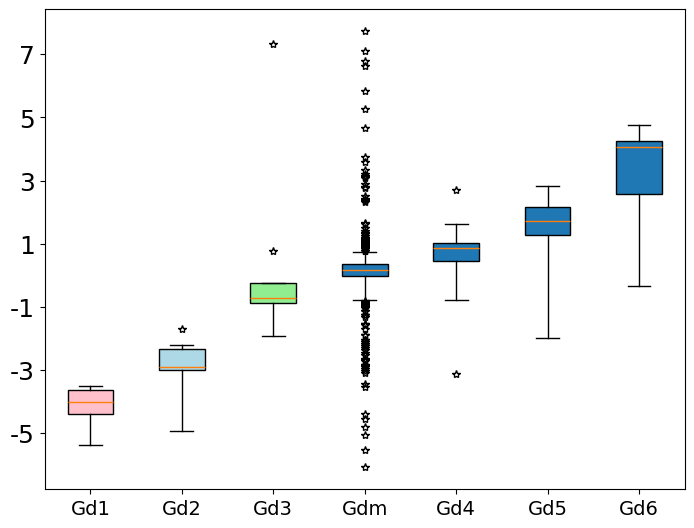

TOFShift+10.5
precise quantify:684
count:911
0.845


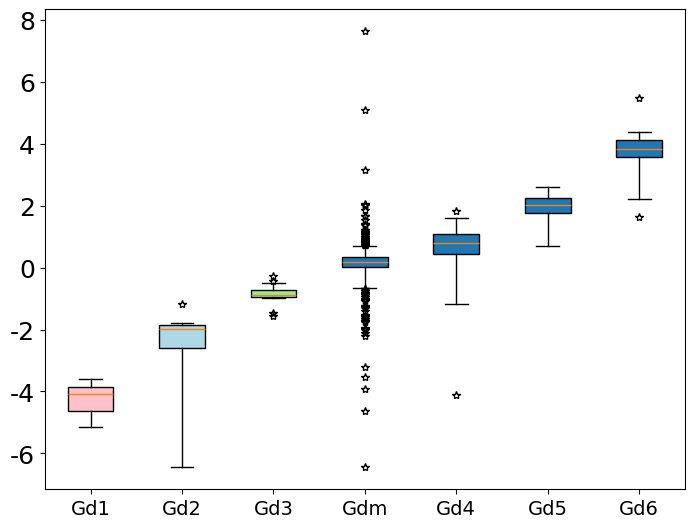

TOFShift+10.4
precise quantify:680
count:908
0.842


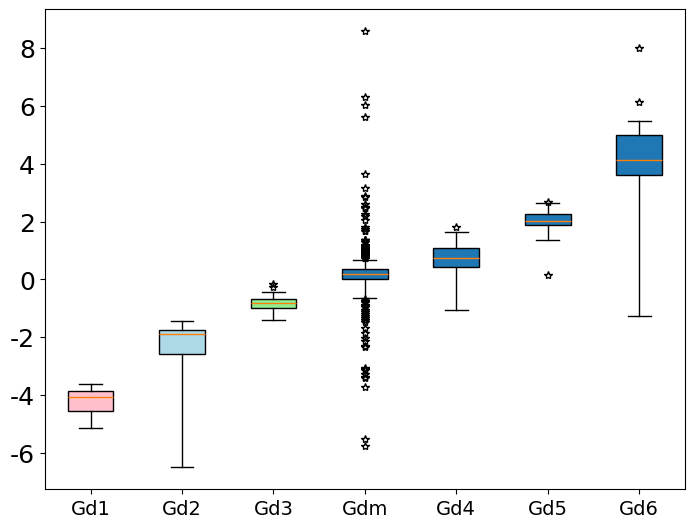

TOFShift+15.4
precise quantify:673
count:909
0.839


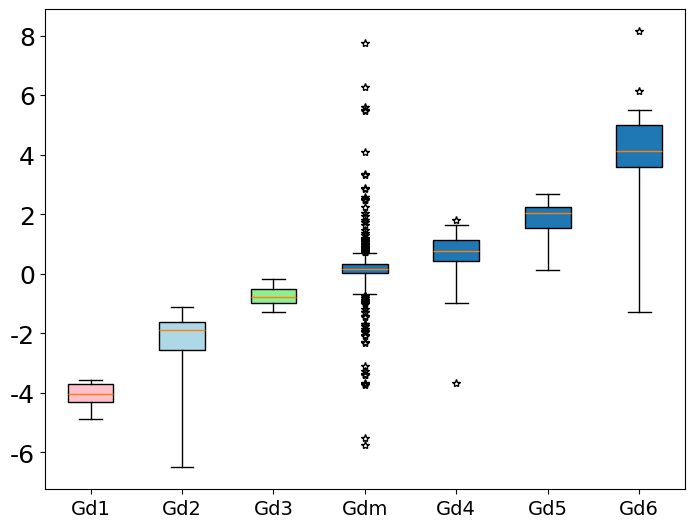

TOFShift+5.4
precise quantify:614
count:900
0.805


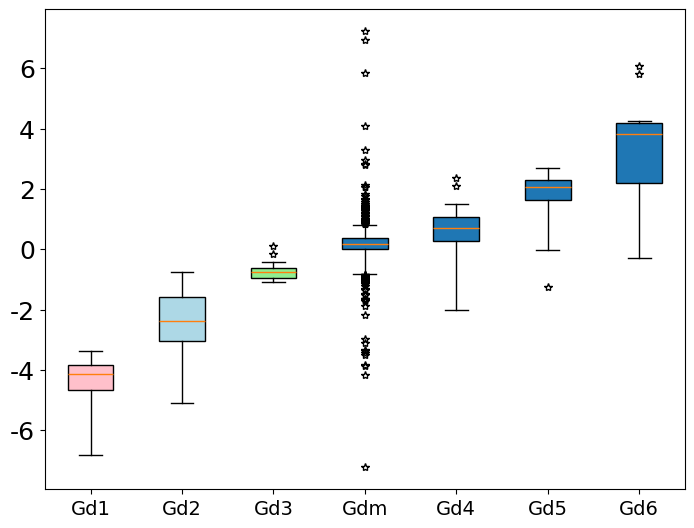

TOFShift+5.5
precise quantify:643
count:904
0.822


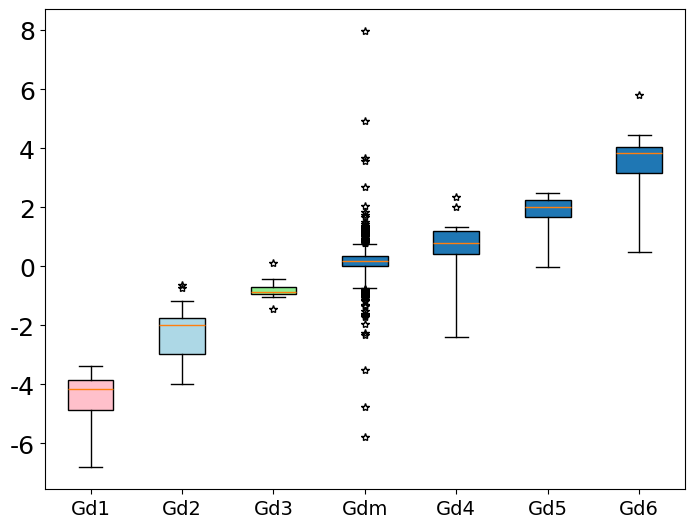

TOFShift+15.5
precise quantify:679
count:913
0.842


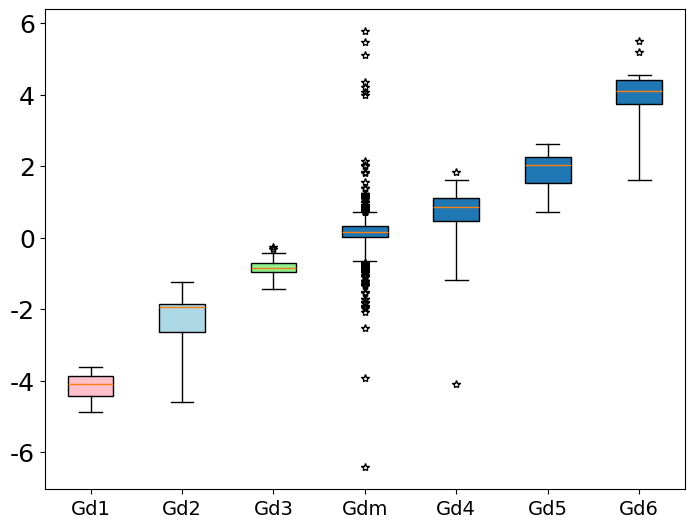

TOFShift+15.2
precise quantify:497
count:697
0.716


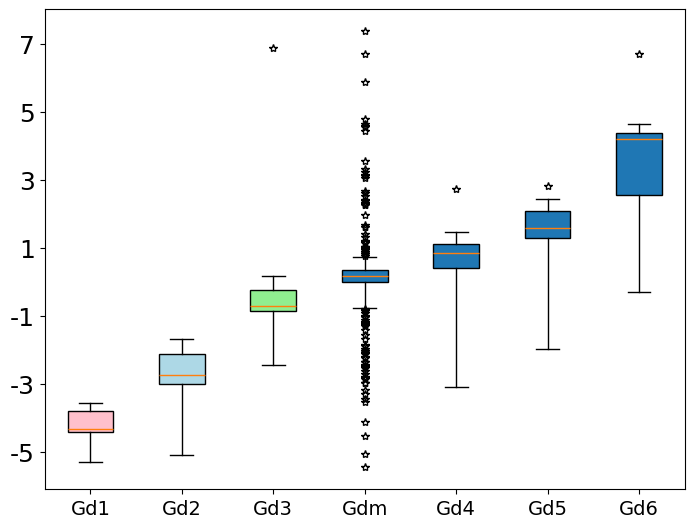

TOFShift+5.2
precise quantify:419
count:708
0.661


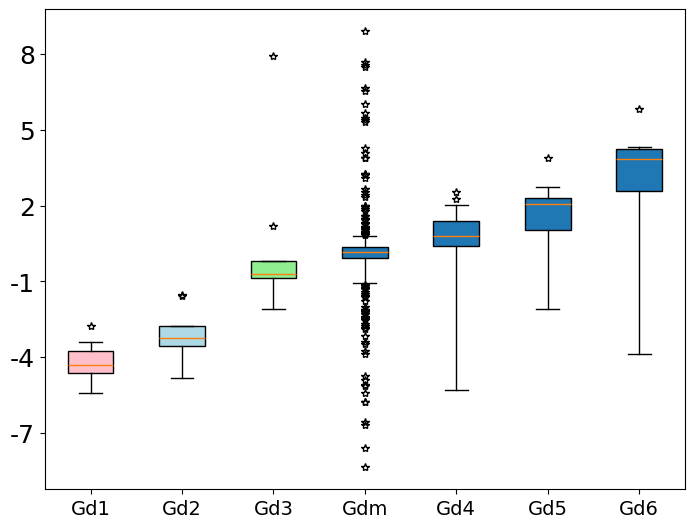

TOFShift+5.3
precise quantify:561
count:877
0.772


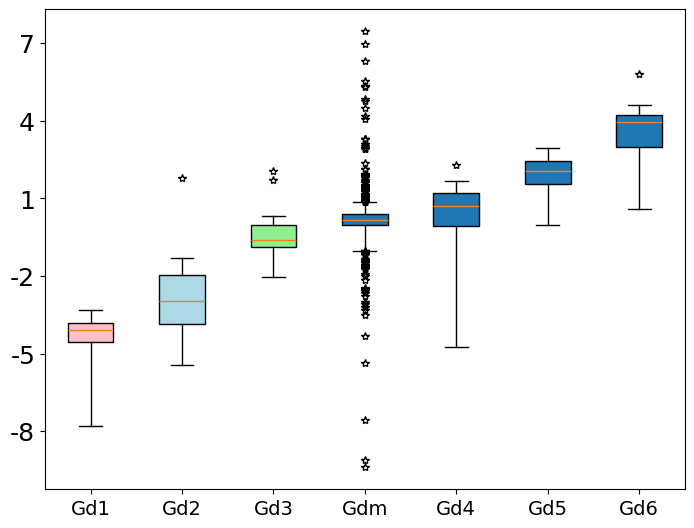

TOFShift+15.3
precise quantify:615
count:883
0.803


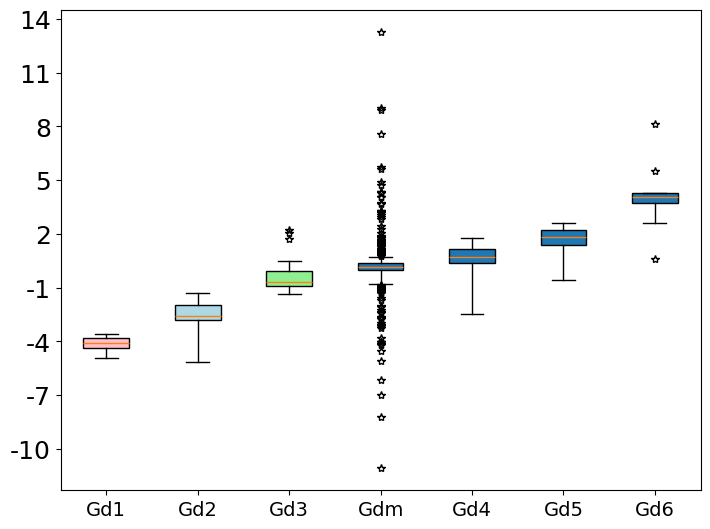

TOFShift+15.1
precise quantify:172
count:254
0.47


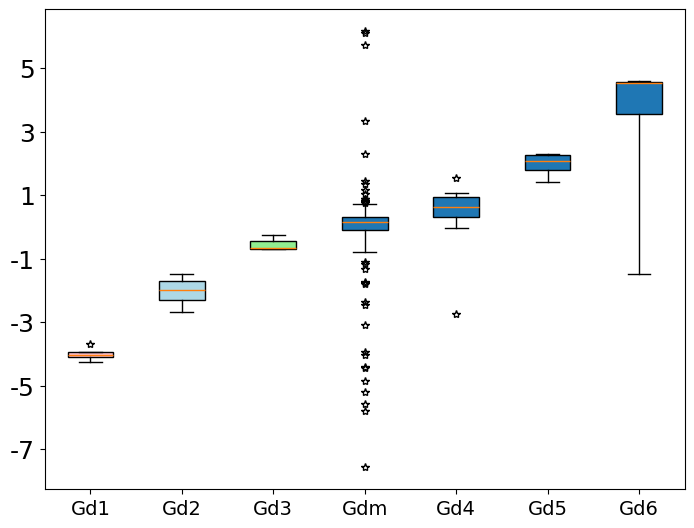

TOFShift+5.1
precise quantify:131
count:290
0.375


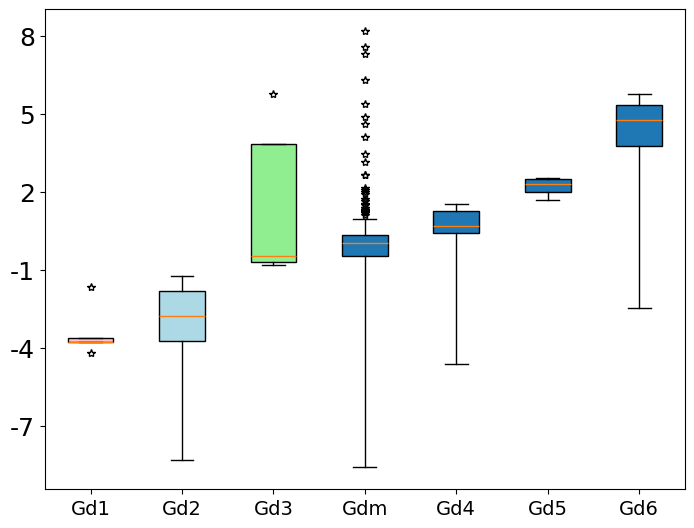

In [72]:
mzmine_dir = 'data/MZMINE3/TOFShift-raw'
benchmark_path = 'data/FeatureTOFShift.csv'
type = 'TOFShift'
boxplot(mzmine_dir, benchmark_path, type)

 ### The best is 10.5, which means ppm=10, rt_tolerance = 0.5

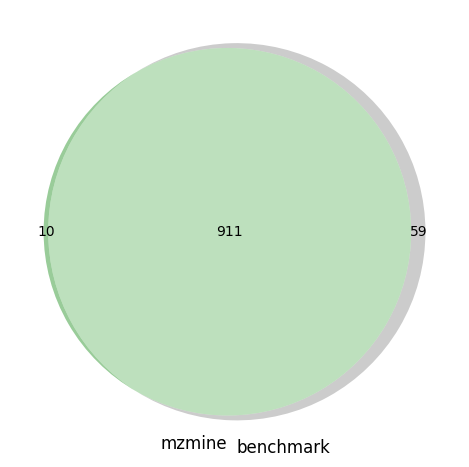

TOFShift+10.5
precise quantify:684
count:911
0.845


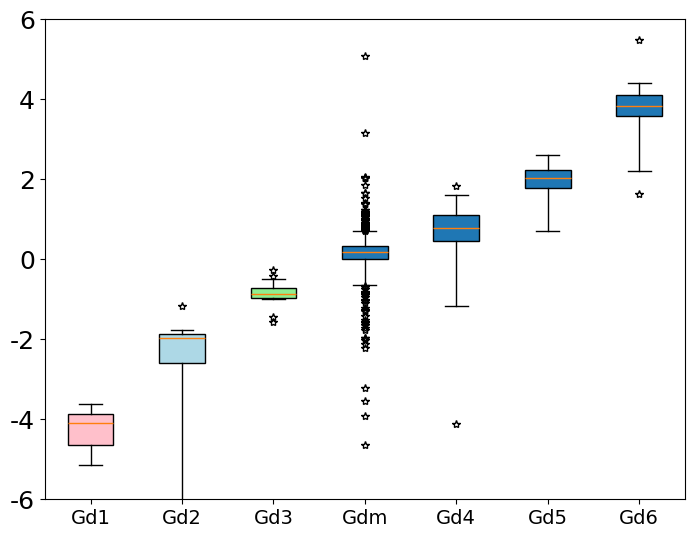

In [73]:
mzmine_path = 'data/MZMINE3/TOFShift-raw/Aligned_feature_list_gap-filled-10-0.5.csv'
def plot_best(mzmine_path, benchmark_path, type):
    df1, df2 = filter_data(mzmine_path, benchmark_path, type)
    match = re.search(r'-(\d+)-(\d+\.\d+)', mzmine_path)
    if match:
        number1 = int(match.group(1)) 
        number2 = float(match.group(2)) 
        df1, df2 = find_couple(df1, df2, number1, number2)
        plot_venn(df1, df2, type, name=number1 + number2)
        plot_log(df1, type, name=number1 + number2, lim=6, save=True)
plot_best(mzmine_path, benchmark_path, type)

## PeakDetective

In [22]:
import os
import re

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn2


def filter_data(SA_path, SB_path, benchmark_path):
    df_SA = pd.read_csv(SA_path)
    df_SB = pd.read_csv(SB_path)

    df_SB_last_five = df_SB.iloc[:, -5:]

    merged_df = pd.concat([df_SA, df_SB_last_five], axis=1)

    df_benchmark = pd.read_csv(benchmark_path)
    df_clean = merged_df[(merged_df != 0).all(axis=1)]  
    df_cleaned = df_clean[df_clean.notnull().all(axis=1)]  
    return df_cleaned, df_benchmark


def find_couple(df_cleaned, df_benchmark):
    df_cleaned.rename(columns={df_cleaned.columns[0]: 'Compound Name'}, inplace=True)
    df_cleaned = pd.merge(df_cleaned, df_benchmark, on=['Compound Name'], how='inner')

    return df_cleaned, df_benchmark


def plot_venn(df1, df2, type, name):
    set1 = set(df1['Compound Name'])
    set2 = set(df2['Compound Name'])
    venn2([set1, set2],
          set_labels=["mzmine", "benchmark"], set_colors=["green", "grey"])
    plt.tight_layout()
    # plt.savefig(f'peakdetective{type}+{name}' + "venn.png", dpi=300)
    plt.show()
    # plt.close()



def plot_boxplot(df, name, precision, lim, n='fc'):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    graph = ax.boxplot(
        [
            df[df["Compound concentration ratio"] == "1/16"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/4"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/2"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "2/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "4/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "16/1"].loc[:, n],
        ],
        vert=True,
        patch_artist=True,
        labels=["Gd1", "Gd2", "Gd3", "Gdm", "Gd4", "Gd5", "Gd6"],
        sym='*'
    )

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(graph['boxes'], colors):
        patch.set_facecolor(color)
    plt.tight_layout()

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    plt.yscale('log', base=2)
    import numpy as np
    if lim != 0:
        plt.ylim(1 / 2 ** lim,  2 ** lim)
    ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    # plt.savefig(f"peakdetective{name}+{precision}.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()



def compute_average_and_cv(group_name, column_names, df):

    try:
        group_columns = [f'{column_name}' for column_name in column_names]

        relevant_data = df.select_dtypes(include='number')[group_columns]

        avg = relevant_data.mean(axis=1)
        std = relevant_data.std(axis=1)

        cv = std.where(std != 0, 0) / avg * 100

        return {'AVG': avg, 'CV': cv}
    except Exception as e:
        print(f"Error processing group {group_name}: {e}")
        return {}


def plot_log(df1, type, name,lim,save=False):
    df1 = df1[df1.notnull().all(axis=1)]  
    all_columns = df1.columns.tolist()
    if type == 'TOF' or type == 'TOFShift':
        sample_a_columns = all_columns[3:7]
        sample_b_columns = all_columns[8:12]
    elif type == 'QE' or type == 'QEShift':
        sample_a_columns = all_columns[3:8]
        sample_b_columns = all_columns[8:13]

    sample_a_results = compute_average_and_cv('SampleA', sample_a_columns, df1)
    sample_b_results = compute_average_and_cv('SampleB', sample_b_columns, df1)

    df1.loc[:, 'AVG-A'] = sample_a_results['AVG']
    df1.loc[:, 'CV-A'] = sample_a_results['CV']
    df1.loc[:, 'AVG-B'] = sample_b_results['AVG']
    df1.loc[:, 'CV-B'] = sample_b_results['CV']

    df1.loc[:, 'fc'] = df1.loc[:, 'AVG-B'] / df1.loc[:, 'AVG-A']
    df1.loc[:, 'ratio'] = df1.loc[:, 'fc'] / df1.loc[:, 'Fold change']

    df1 = df1.sort_values(by='Compound Name')
    duplicate_rows = df1[df1.duplicated(subset=['Compound Name'], keep=False)]
    from itertools import groupby
    grouped = [(key, list(group)) for key, group in
                groupby(duplicate_rows.index, key=lambda x: duplicate_rows.loc[x, duplicate_rows.columns[-10]])]

    other_numbers_in_group = []
    # duplicate_rows['abs_'] = abs(duplicate_rows['ratio'] - 1)
    for key, group in grouped:
        min_id = min(group, key=lambda x: (abs(duplicate_rows.loc[x, 'rt'] - duplicate_rows.loc[x, 'True RT'])))

        for id in group:
            if id != min_id:
                other_numbers_in_group.append(id)

    df1.drop(other_numbers_in_group, inplace=True)

    score = calculate_precision(df1, name, type)
    print(score)
    plot_boxplot(df1, name, score, lim)
    if save:
        df1.to_csv(f'peakdetective_{type}.csv', index=False)


def calculate_precision(df, name, type):
    print(f'{type}+{name}')
    df_filtered = df[(df['ratio'] > 0.8) & (df['ratio'] < 1.2)]
    count = df_filtered.shape[0]
    print(f"precise quantify:{count}")
    print(f"count:{df.shape[0]}",)
    # print(f"precsion:{count/df.shape[0]}")
    if type == 'TOF' or type == 'TOFShift':
        return round((count/df.shape[0] + df.shape[0] / 970)/2, 3)
    elif type == 'QE' or type == 'QEShift':
        return round((count/df.shape[0] + df.shape[0] / 836)/2, 3)

### QE-benchmark feature table

QE+SA-qe_5.csv
precise quantify:496
count:835
0.796


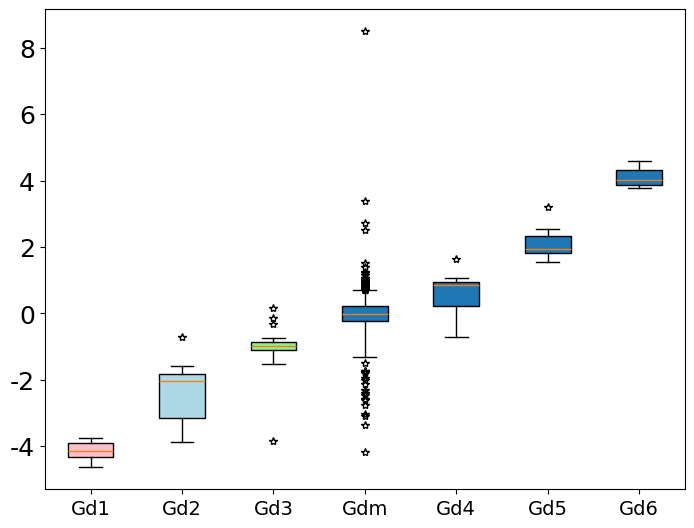

In [23]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qe_5.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qe_5.csv'
    benchmark_path = 'data/FeatureQE.csv'
    type = 'QE'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    plot_log(df1, type, name= number1,lim=0)

QE+SA-qe_10.csv
precise quantify:648
count:834
0.887


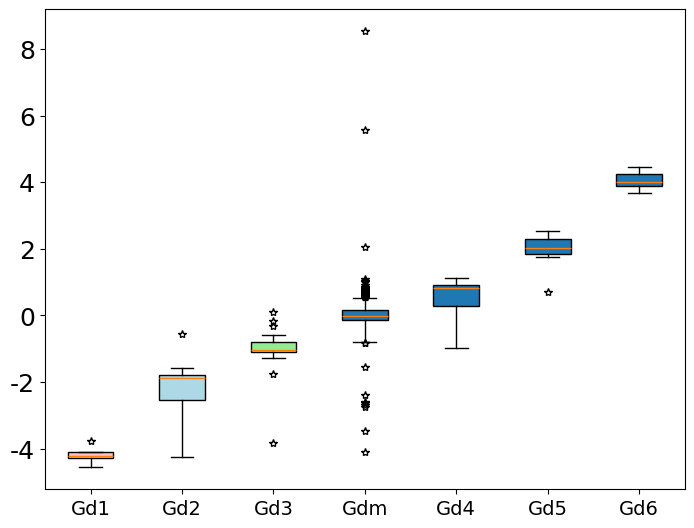

In [24]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qe_10.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qe_10.csv'
    benchmark_path = 'data/FeatureQE.csv'
    type = 'QE'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    plot_log(df1, type, name= number1,lim=0)

QE+SA-qe_15.csv
precise quantify:687
count:833
0.911


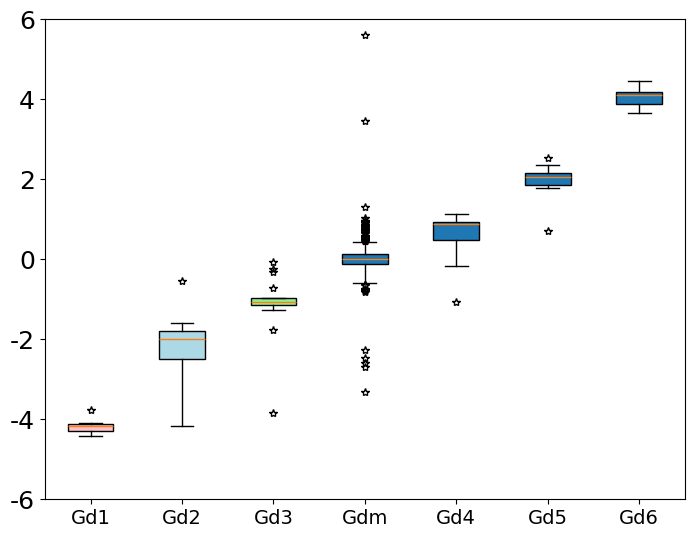

In [25]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qe_15.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qe_15.csv'
    benchmark_path = 'data/FeatureQE.csv'
    type = 'QE'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    plot_log(df1, type, name= number1,lim=6,save=True)

### QE- feature table with RT drift

(770, 13)
(770, 19)
QEShift+SA-qeb_5.csv
precise quantify:400
count:770
0.72


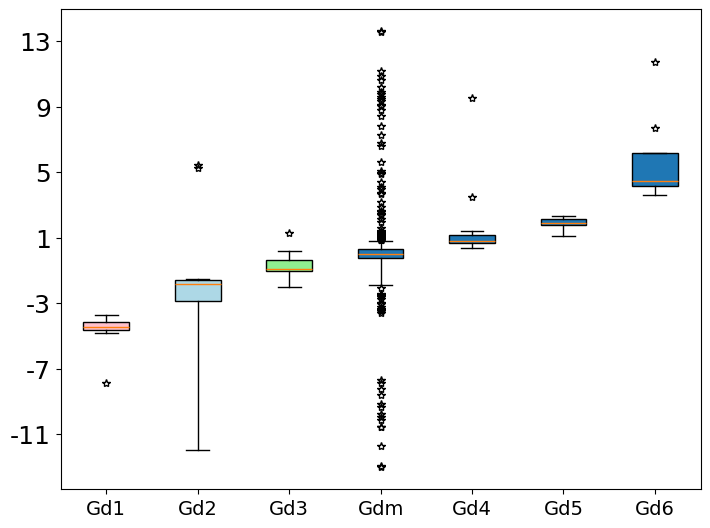

In [26]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qeb_5.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qeb_5.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    type = 'QEShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

(772, 13)
(772, 19)
QEShift+SA-qeb_10.csv
precise quantify:518
count:772
0.797


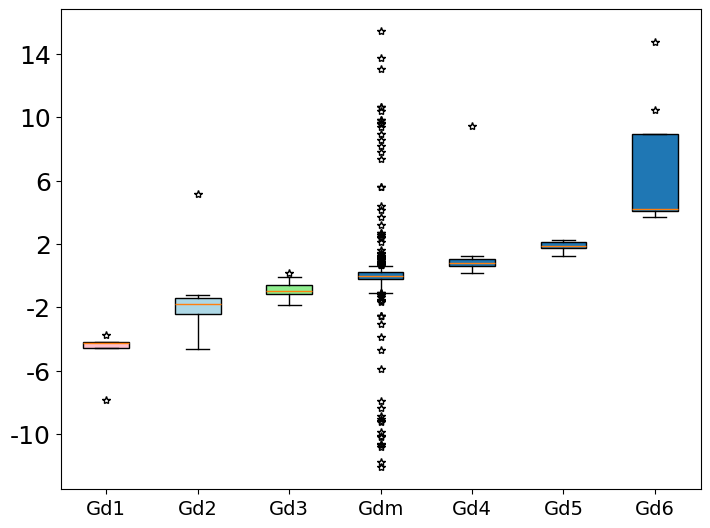

In [27]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qeb_10.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qeb_10.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    type = 'QEShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

(768, 13)
(768, 19)
QEShift+SA-qeb_15.csv
precise quantify:528
count:768
0.803


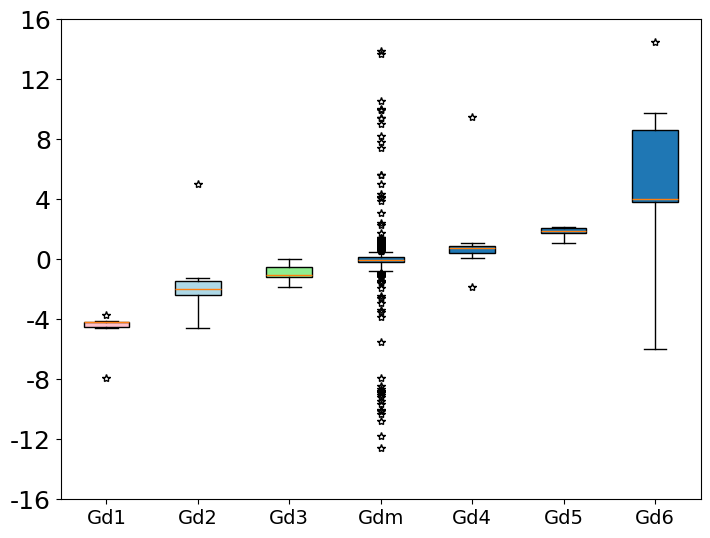

In [28]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/QE/SA-qeb_15.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/QE/SB-qeb_15.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    type = 'QEShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=16,save=True)

### TOF-benchmark feature table

(952, 12)
(952, 18)
TOF+SA-tof_5.csv
precise quantify:436
count:952
0.72


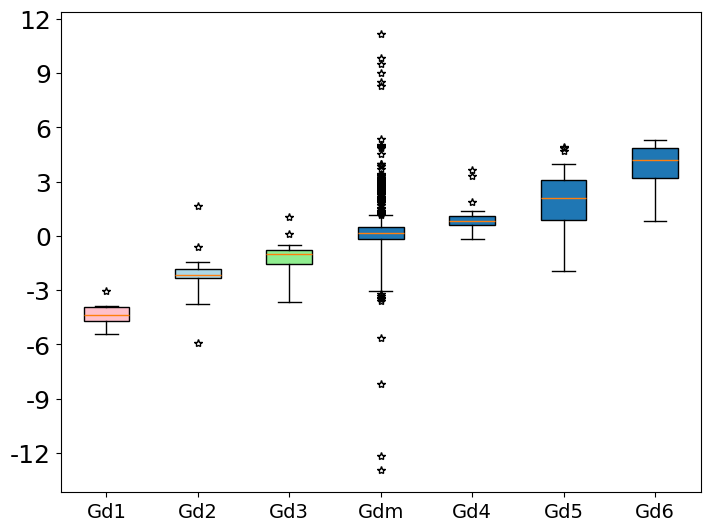

In [29]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tof_5.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tof_5.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    type = 'TOF'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

(962, 12)
(962, 18)
TOF+SA-tof_10.csv
precise quantify:564
count:962
0.789


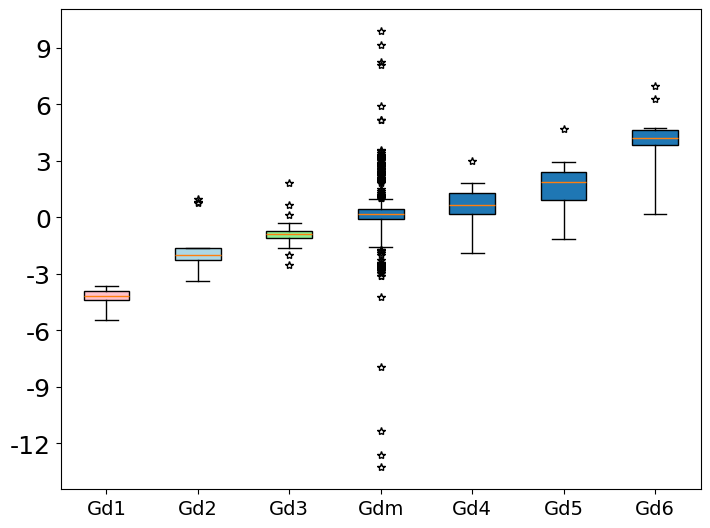

In [30]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tof_10.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tof_10.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    type = 'TOF'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

### The best one

(964, 12)
(964, 18)
TOF+SA-tof_15.csv
precise quantify:589
count:964
0.802


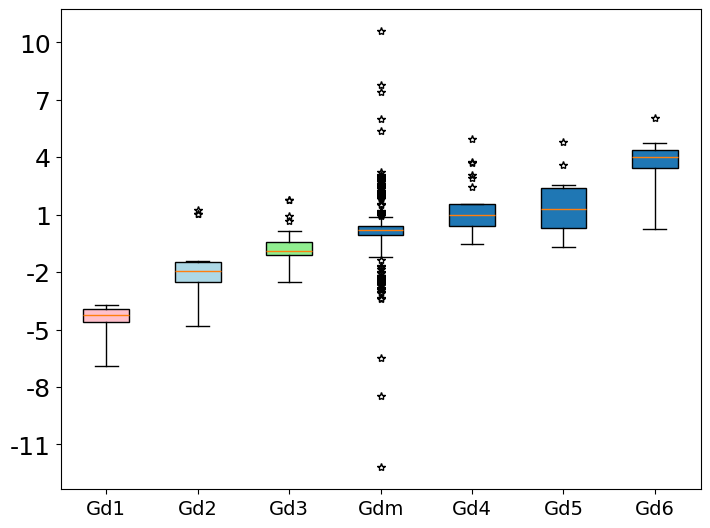

In [31]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tof_15.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tof_15.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    type = 'TOF'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0,save=True)

### TOF feature table with RT drift

(856, 12)
(856, 18)
TOFShift+SA-tofb_5.csv
precise quantify:286
count:856
0.608


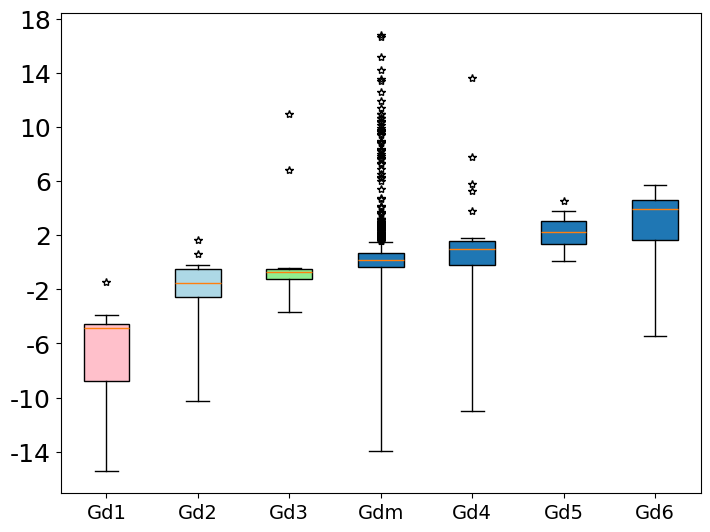

In [32]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tofb_5.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tofb_5.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    type = 'TOFShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

(877, 12)
(877, 18)
TOFShift+SA-tofb_10.csv
precise quantify:356
count:877
0.655


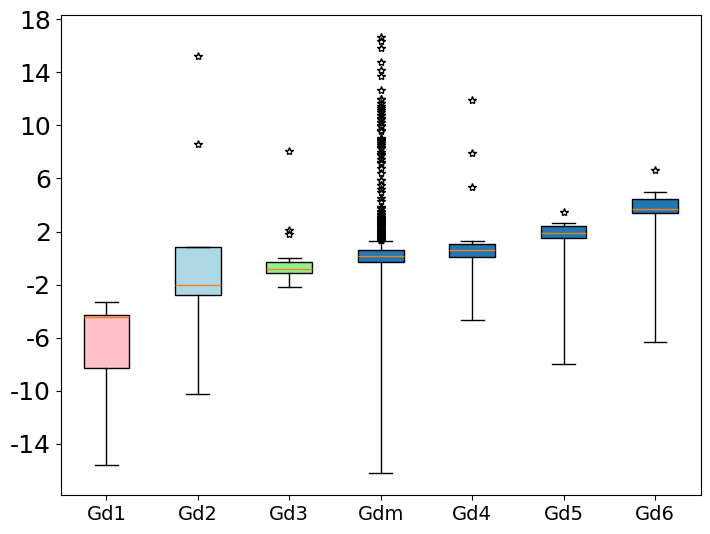

In [33]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tofb_10.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tofb_10.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    type = 'TOFShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=0)

### The best one.

(893, 12)
(893, 18)
TOFShift+SA-tofb_15.csv
precise quantify:400
count:893
0.684


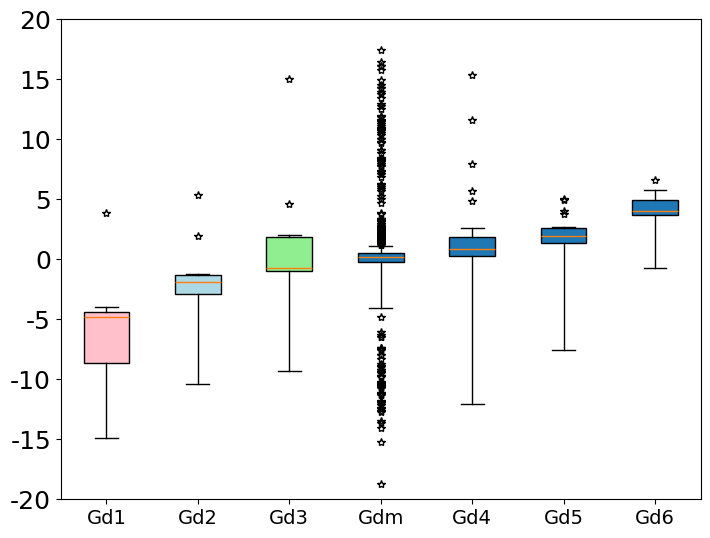

In [34]:
if __name__ == '__main__':
    peakdetective_SA_dir = 'data/PEAKDETECTIVE/TOF/SA-tofb_15.csv'
    peakdetective_SB_dir = 'data/PEAKDETECTIVE/TOF/SB-tofb_15.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    type = 'TOFShift'
    df1, df2 = filter_data(peakdetective_SA_dir, peakdetective_SB_dir, benchmark_path)
    print(df1.shape)
    number1 = peakdetective_SA_dir.split('/')[-1]
    df1, df2 = find_couple(df1, df2)
    print(df1.shape)
    plot_log(df1, type, name= number1,lim=20,save=True)

## PeakFormer

In [51]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2


def filter_duplicate(ms_path, benchmark_path):
    df_ms = pd.read_csv(ms_path)
    df_ms = df_ms[['Image_Path', 'Compound Name', 'Retention Time', 'Area']]
    df_QE = pd.read_csv(benchmark_path)
    merged_df = pd.merge(df_ms, df_QE, on='Compound Name')

    grouped = merged_df.groupby('Compound Name')
    num_unique = merged_df['Image_Path'].nunique()

    drop = []
    for a, b in grouped:
        if len(b) > num_unique:
            grouped_ = b.groupby('Image_Path')
            for x, y in grouped_:
                diff = abs(y.iloc[:]['Retention Time'] - y.iloc[:]['RT'])
                min_diff_index = diff.idxmin()
                other_index = diff.index[diff.index != min_diff_index]
                drop.append(other_index)

    indices_to_remove = [item for sublist in [i.tolist() for i in drop if len(i) > 0] for item in sublist]

    single_df = merged_df.drop(indices_to_remove, axis=0)
    return single_df


def post_process(old_df, benchmark_path, number, rt_tolerance):
    old_df = old_df[['Image_Path', 'Compound Name', 'Retention Time', 'Area']]

    df_new = old_df.pivot(index='Compound Name', columns='Image_Path', values=['Retention Time', 'Area'])

    df_new.columns = [f'{col[1]}_{col[0]}' for col in df_new.columns]

    df_new.reset_index(inplace=False)

    df_QE = pd.read_csv(benchmark_path)
    merged_df = pd.merge(df_new, df_QE, on='Compound Name')

    for col in merged_df.columns[1:number]:
        merged_df[col] = abs(merged_df[col] - merged_df['RT'])

    merged_df = merged_df[(merged_df.iloc[:, 1:number] <= rt_tolerance).all(axis=1)]
    print(merged_df.shape)
    # merged_df = merged_df.drop(merged_df.columns[1:number], axis=1)

    return merged_df


def plot_boxplot(df, name, type, precision, n='fc'):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    graph = ax.boxplot(
        [
            df[df["Compound concentration ratio"] == "1/16"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/4"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/2"].loc[:, n],
            df[df["Compound concentration ratio"] == "1/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "2/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "4/1"].loc[:, n],
            df[df["Compound concentration ratio"] == "16/1"].loc[:, n],
        ],
        vert=True,
        patch_artist=True,
        labels=["Gd1", "Gd2", "Gd3", "Gdm", "Gd4", "Gd5", "Gd6"],
        sym='*'
    )

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(graph['boxes'], colors):
        patch.set_facecolor(color)
    plt.tight_layout()

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    plt.yscale('log', base=2)
    import numpy as np
    plt.ylim(1 / 2**6,  2**6)
    ax.set_yticklabels([int(1 * np.log2(y)) for y in ax.get_yticks()], fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
#     plt.savefig(f"{type}+{name}+{precision}.png", dpi=300, bbox_inches="tight")
    plt.show()
    # plt.close()



def compute_average_and_cv(group_name, column_names, df):

    try:
        group_columns = [f'{column_name}' for column_name in column_names]

        relevant_data = df.select_dtypes(include='number')[group_columns]

        avg = relevant_data.mean(axis=1)
        std = relevant_data.std(axis=1)

        cv = std.where(std != 0, 0) / avg * 100

        return {'AVG': avg, 'CV': cv}
    except Exception as e:
        print(f"Error processing group {group_name}: {e}")
        return {}


def plot_log(df1, type, name, output_path):
    df1 = df1[df1.notnull().all(axis=1)]
    all_columns = df1.columns.tolist()

    if type == 'TOF' or type == 'TOFShift':
        import pandas as pd
        sample_a_columns = [all_columns[i] for i in [-14, -13, -8, -7]]
        sample_b_columns = [all_columns[i] for i in [-12, -11, -10, -9]]
    elif type == 'QE' or type == 'QEShift':
        sample_a_columns = all_columns[-16:-11]
        sample_b_columns = all_columns[-11:-6]

    sample_a_results = compute_average_and_cv('SampleA', sample_a_columns, df1)
    sample_b_results = compute_average_and_cv('SampleB', sample_b_columns, df1)

    df1.loc[:, 'AVG-A'] = sample_a_results['AVG']
    df1.loc[:, 'CV-A'] = sample_a_results['CV']
    df1.loc[:, 'AVG-B'] = sample_b_results['AVG']
    df1.loc[:, 'CV-B'] = sample_b_results['CV']

    df1.loc[:, 'fc'] = df1.loc[:, 'AVG-B'] / df1.loc[:, 'AVG-A']
    df1.loc[:, 'ratio'] = df1.loc[:, 'fc'] / df1.loc[:, 'Fold change']

    df_cleaned = df1[df1.notnull().all(axis=1)]

    precsion = calculate_precision(df_cleaned, name, type)
    print(precsion)
    plot_boxplot(df_cleaned, name, type, precsion)
    df_cleaned = df_cleaned.drop(df_cleaned.columns[1:11], axis=1)
    df_cleaned.to_csv(output_path)


def calculate_precision(df, name, type):
    print(f'{type}+{name}')
    df_filtered = df[(df['ratio'] > 0.8) & (df['ratio'] < 1.2)]
    count = df_filtered.shape[0]
    print(f"precise quantify:{count}")
    print(f"count:{df.shape[0]}",)
    if type == 'TOF' or type == 'TOFShift':
        return round((count/df.shape[0] + df.shape[0] / 970)/2, 3)
    elif type == 'QE' or type == 'QEShift':
        return round((count/df.shape[0] + df.shape[0] / 836)/2, 3)

(609, 27)
QE+PeakFormer
precise quantify:593
count:609
0.851


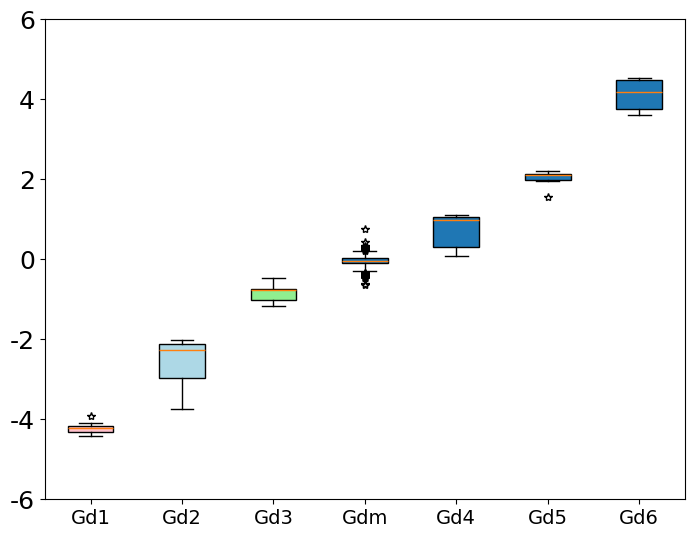

(756, 27)
QE+PeakFormer
precise quantify:734
count:756
0.938


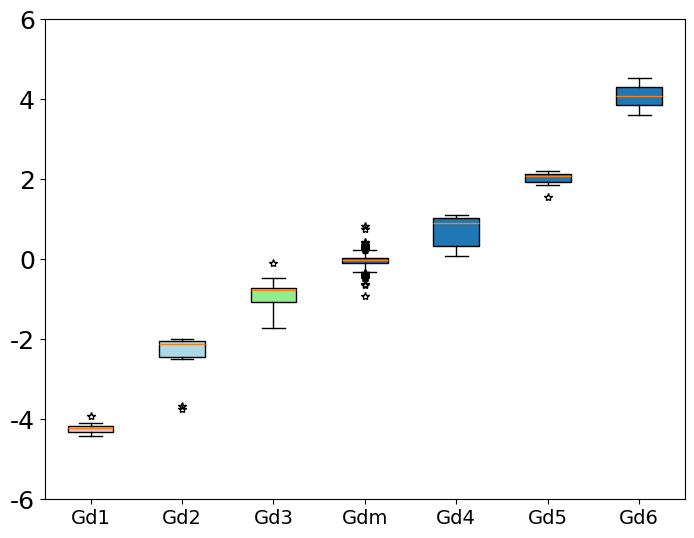

(829, 27)
QE+PeakFormer
precise quantify:801
count:829
0.979


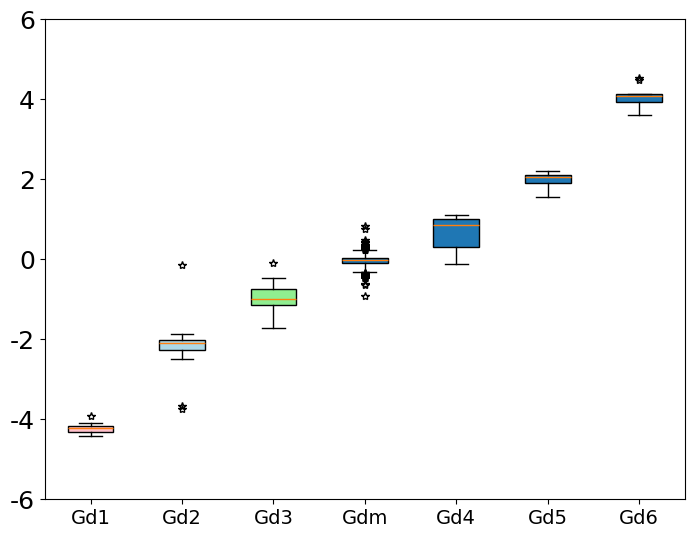

(830, 27)
QE+PeakFormer
precise quantify:801
count:830
0.979


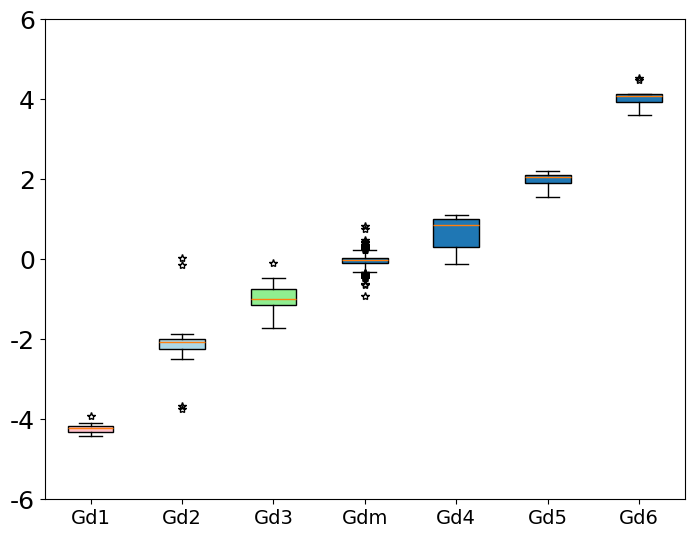

(830, 27)
QE+PeakFormer
precise quantify:801
count:830
0.979


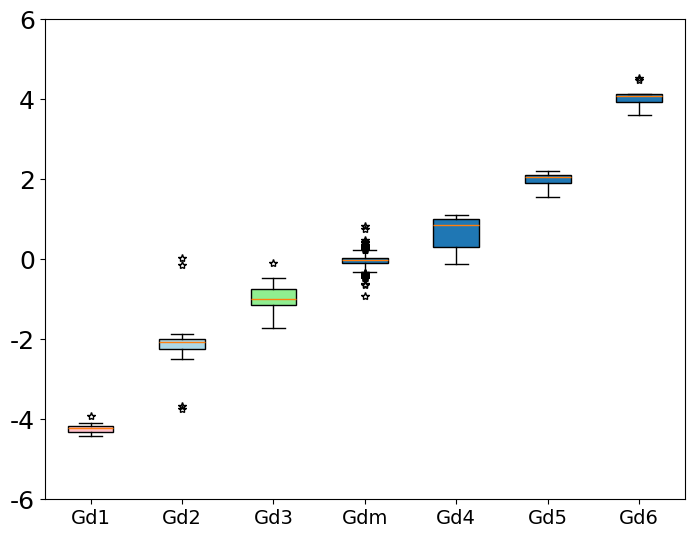

In [52]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/QE/areas.csv'
    benchmark_path = 'data/FeatureQE.csv'
    output_path = 'data/Mine/QE/post-my-qe.csv'
    type = 'QE'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    for i in (0.1,0.2,0.3,0.4,0.5):
        df1 = post_process(df, benchmark_path, 11, i)
        plot_log(df1, type, 'PeakFormer',output_path)

(830, 27)
QE+PeakFormer
precise quantify:801
count:830
0.979


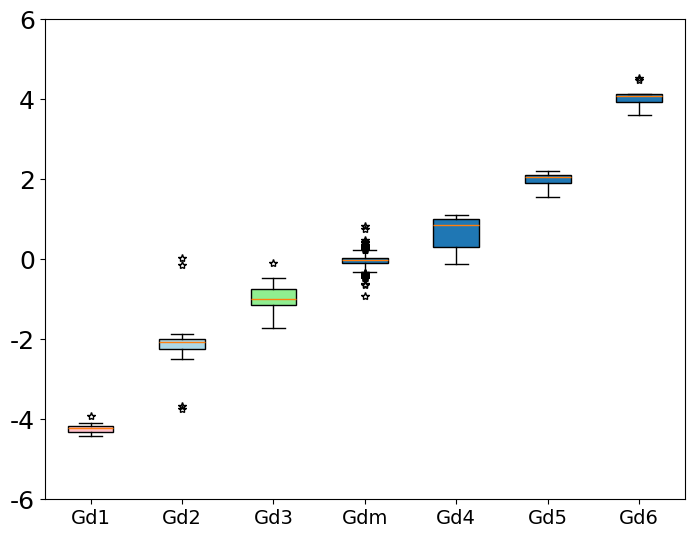

In [53]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/QE/areas.csv'
    benchmark_path = 'data/FeatureQE.csv'
    output_path = 'data/Mine/QE/post-my-qe.csv'
    type = 'QE'
    df1 = post_process(df, benchmark_path, 11, 0.4)
    plot_log(df1, type, 'PeakFormer',output_path)

(232, 27)
QEShift+PeakFormer
precise quantify:223
count:232
0.619


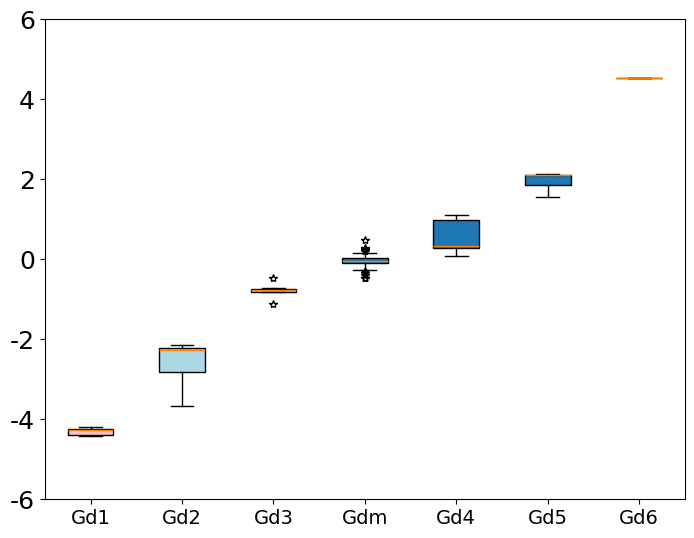

(579, 27)
QEShift+PeakFormer
precise quantify:561
count:579
0.831


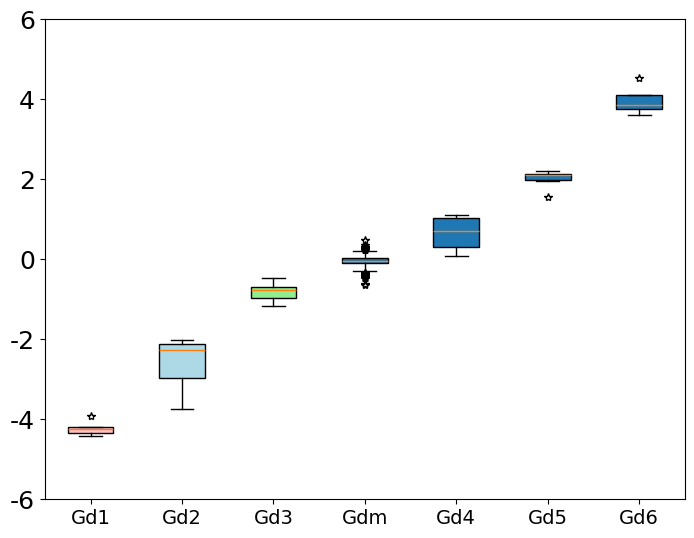

(751, 27)
QEShift+PeakFormer
precise quantify:727
count:751
0.933


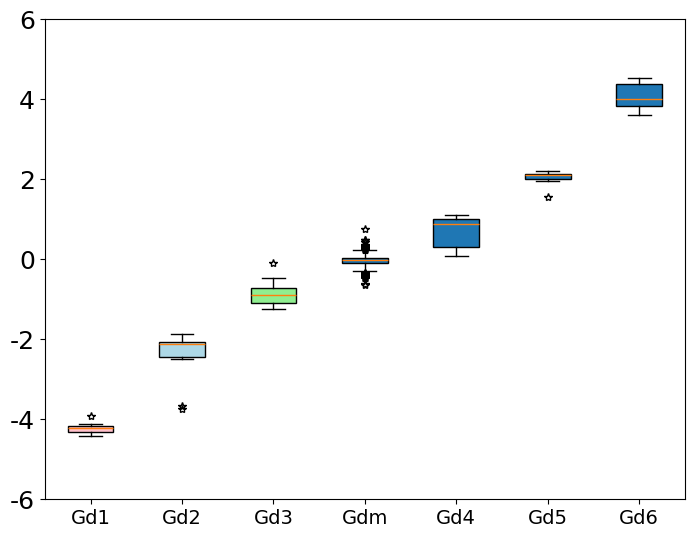

(819, 27)
QEShift+PeakFormer
precise quantify:789
count:819
0.972


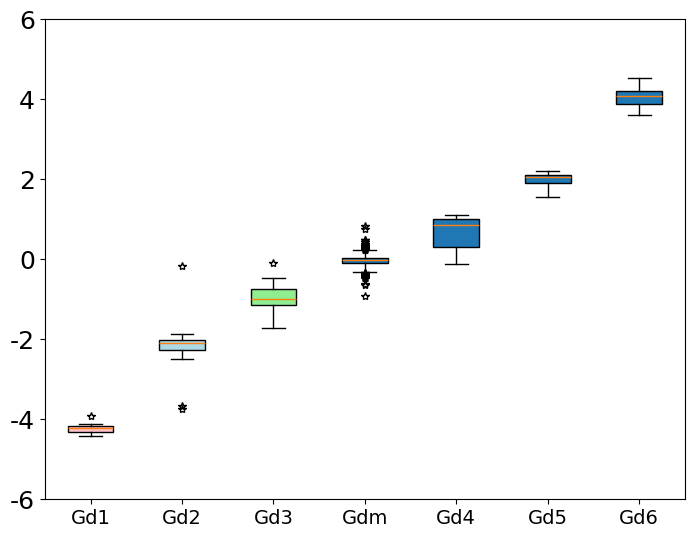

(830, 27)
QEShift+PeakFormer
precise quantify:798
count:830
0.977


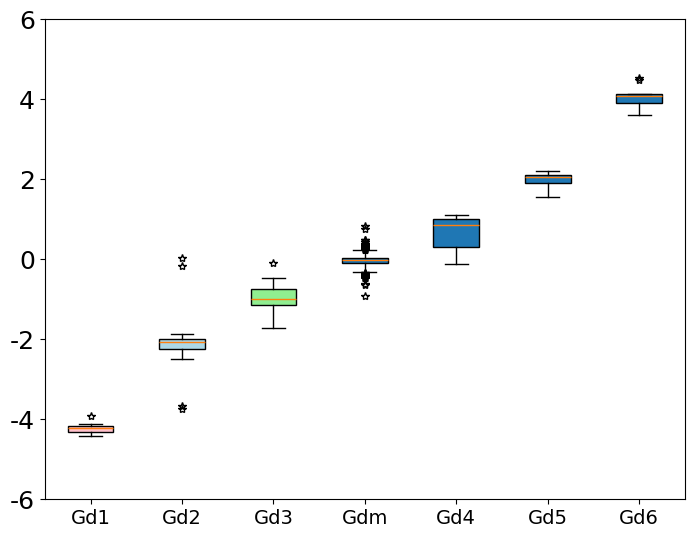

In [54]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/QEShift/areas.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    output_path = 'data/Mine/QEShift/post-my-qe.csv'
    type = 'QEShift'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    for i in (0.1,0.2,0.3,0.4,0.5):
        df1 = post_process(df, benchmark_path, 11, i)
        plot_log(df1, type, 'PeakFormer',output_path)

(830, 27)
QEShift+PeakFormer
precise quantify:798
count:830
0.977


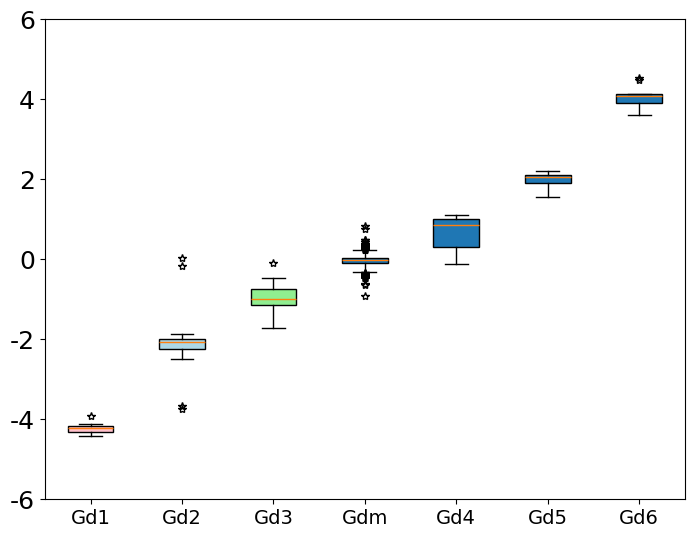

In [55]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/QEShift/areas.csv'
    benchmark_path = 'data/FeatureQEShift.csv'
    output_path = 'data/Mine/QEShift/post-my-qe.csv'
    type = 'QEShift'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    df1 = post_process(df, benchmark_path, 11, 0.5)
    plot_log(df1, type, 'PeakFormer',output_path)

(611, 23)
TOF+PeakFormer
precise quantify:572
count:611
0.783


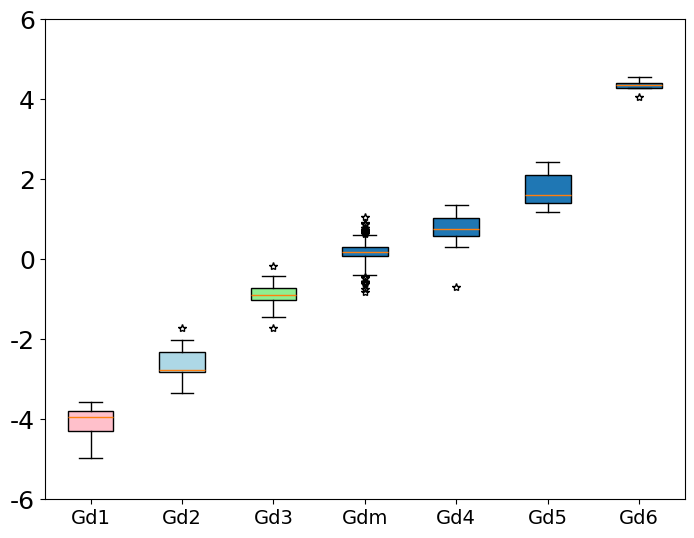

(752, 23)
TOF+PeakFormer
precise quantify:705
count:752
0.856


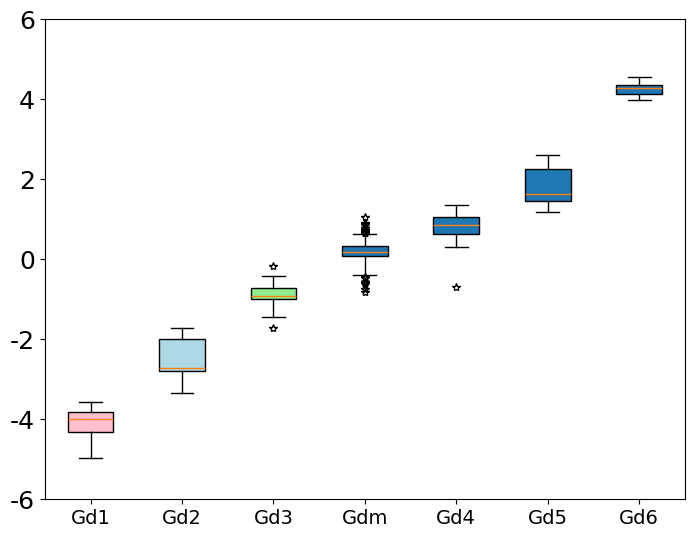

(850, 23)
TOF+PeakFormer
precise quantify:800
count:850
0.909


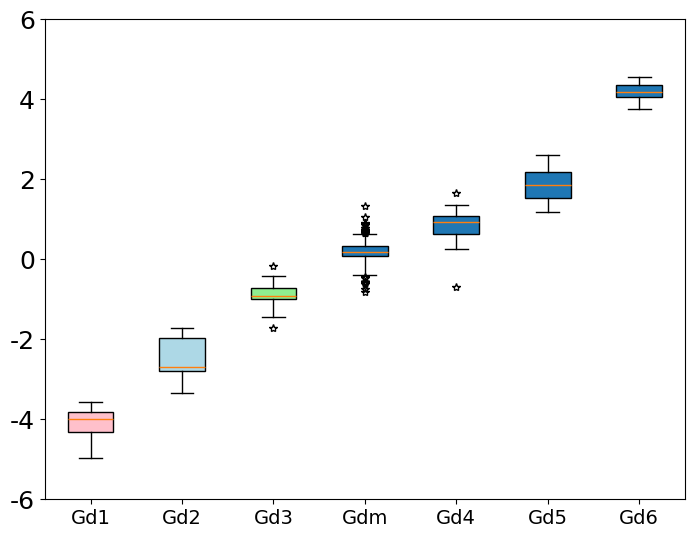

(938, 23)
TOF+PeakFormer
precise quantify:886
count:938
0.956


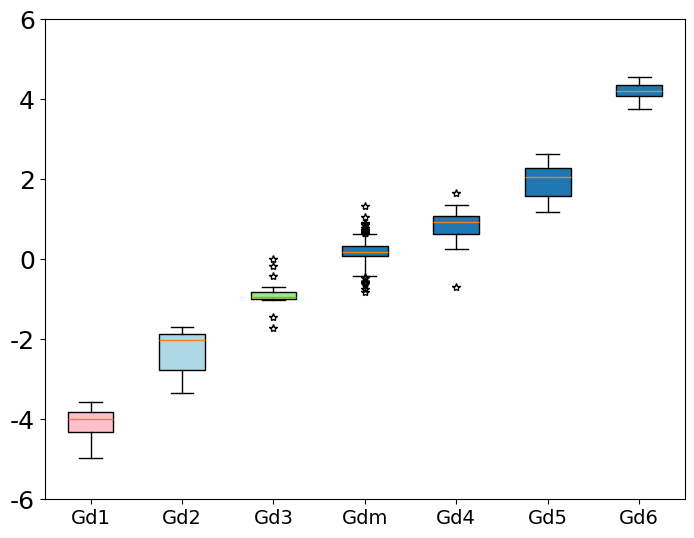

(961, 23)
TOF+PeakFormer
precise quantify:906
count:961
0.967


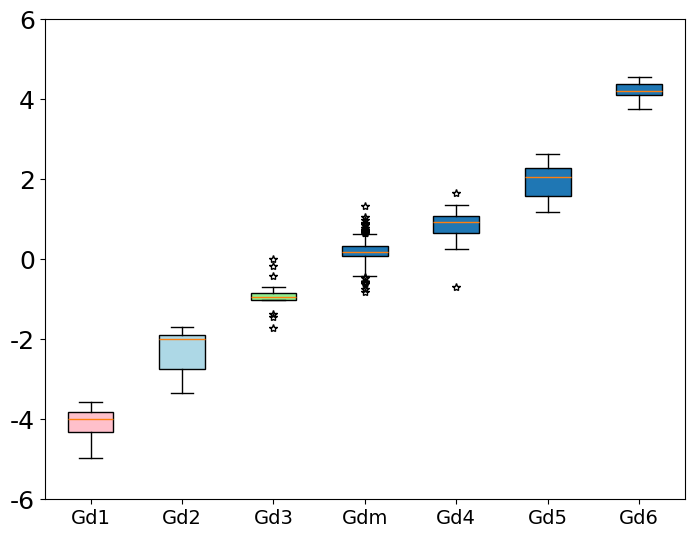

In [56]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/TOF/areas.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    output_path = 'data/Mine/TOF/post-my-tof.csv'
    type = 'TOF'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    for i in (0.1,0.2,0.3,0.4,0.5):
        df1 = post_process(df, benchmark_path, 9, i)
        plot_log(df1, type, 'PeakFormer',output_path)

(961, 23)
TOF+PeakFormer
precise quantify:906
count:961
0.967


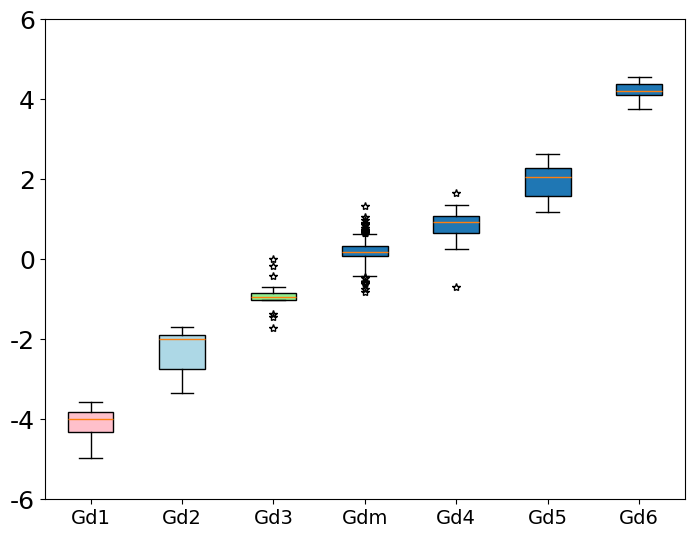

In [57]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/TOF/areas.csv'
    benchmark_path = 'data/FeatureTOF.csv'
    output_path = 'data/Mine/TOF/post-my-tof.csv'
    type = 'TOF'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    df1 = post_process(df, benchmark_path, 9, 0.5)
    plot_log(df1, type, 'PeakFormer',output_path)

(187, 23)
TOFShift+PeakFormer
precise quantify:171
count:187
0.554


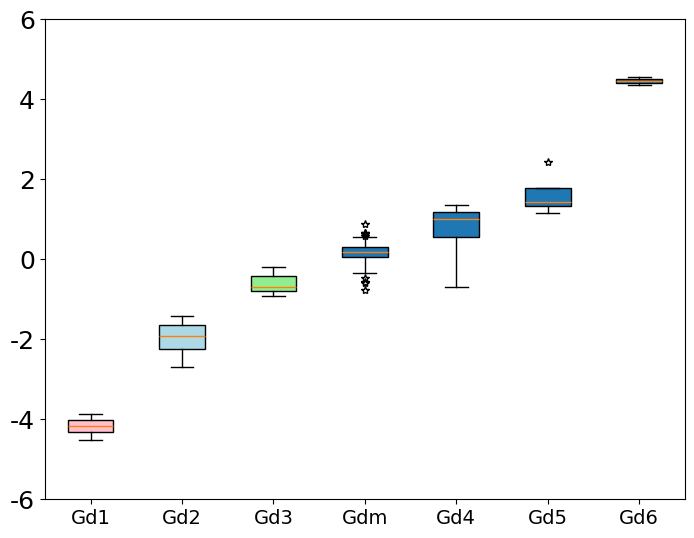

(559, 23)
TOFShift+PeakFormer
precise quantify:517
count:559
0.751


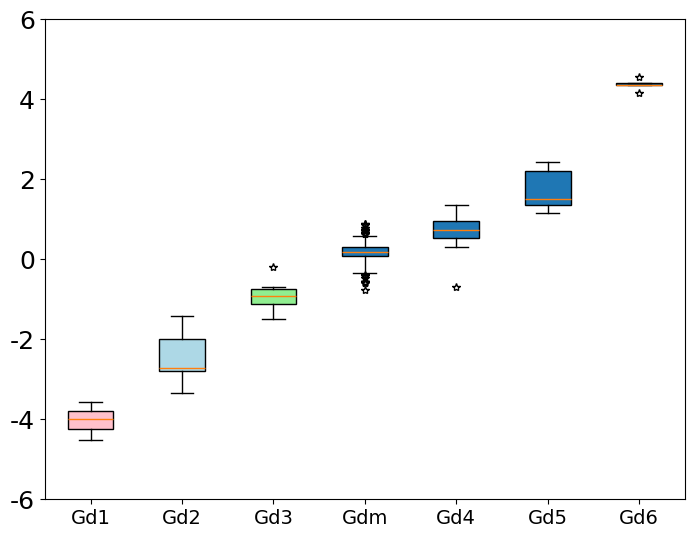

(754, 23)
TOFShift+PeakFormer
precise quantify:701
count:754
0.854


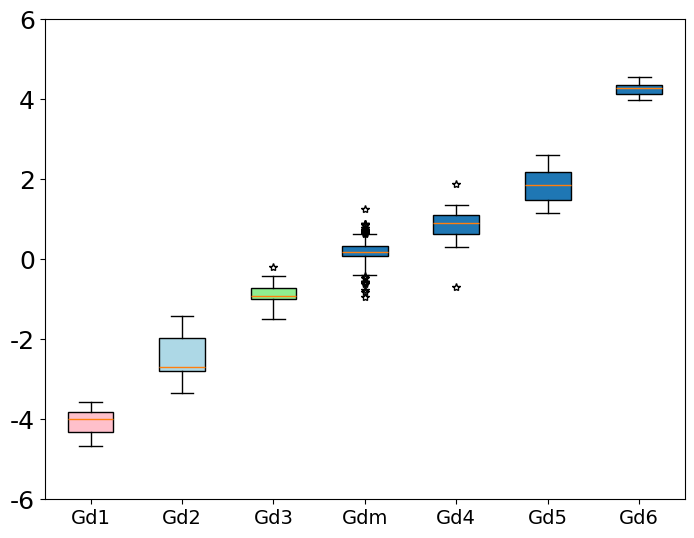

(873, 23)
TOFShift+PeakFormer
precise quantify:814
count:873
0.916


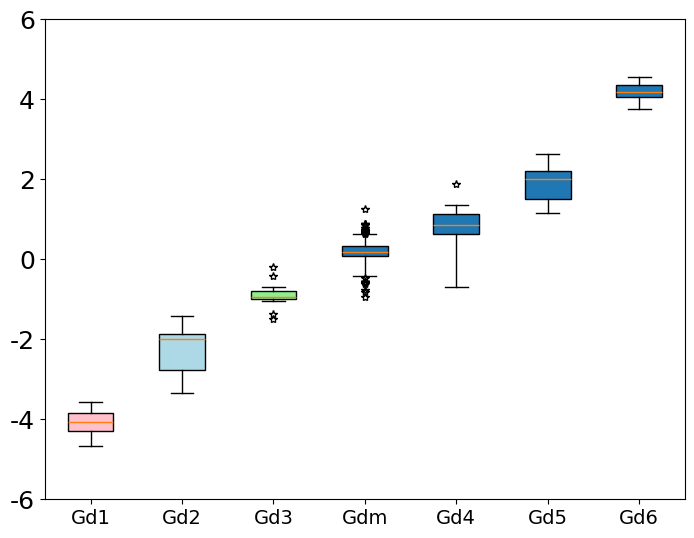

(940, 23)
TOFShift+PeakFormer
precise quantify:877
count:940
0.951


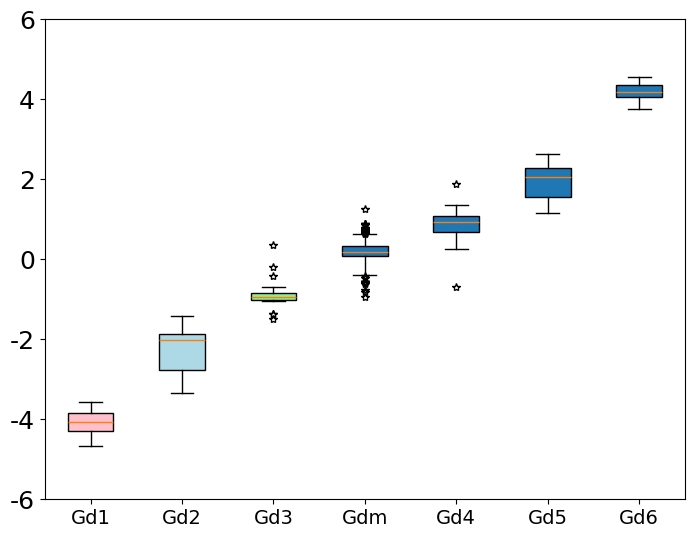

In [58]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/TOFShift/areas.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    output_path = 'data/Mine/TOFShift/post-my-tof.csv'
    type = 'TOFShift'
    df = filter_duplicate(PeakFormer_path, benchmark_path)
    for i in (0.1,0.2,0.3,0.4,0.5):
        df1 = post_process(df, benchmark_path, 9, i)
        plot_log(df1, type, 'PeakFormer',output_path)

(940, 23)
TOFShift+PeakFormer
precise quantify:877
count:940
0.951


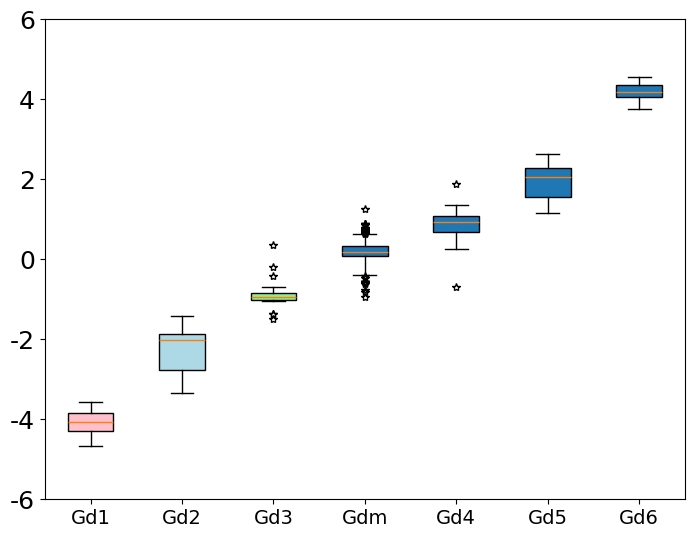

In [59]:
if __name__ == '__main__':
    PeakFormer_path = 'data/Mine/TOFShift/areas.csv'
    benchmark_path = 'data/FeatureTOFShift.csv'
    output_path = 'data/Mine/TOFShift/post-my-tof.csv'
    type = 'TOFShift'
    df = filter_duplicate(PeakFormer_path, benchmark_path)

    df1 = post_process(df, benchmark_path, 9, 0.5)
    plot_log(df1, type, 'PeakFormer',output_path)